In [1]:
using DifferentialEquations, Plots, Flux,DiffEqFlux

## Solving Differential Equations in Julia
We would like to solve the Lotka-Volterra equations describing the dynamics of the population of rabbits and wolves  

<img src = "lotka.png" align="center"/>  

encoded in Julia it looks like

In [2]:
using DifferentialEquations
function lotka_volterra(du,u,p,t)
    x,y = u
    α, β, δ, γ = p
    du[1] = dx = α*x - β*x*y
    du[2] = dy = -δ*y + γ*x*y
end
u0 = [1.0,1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra,u0,tspan,p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

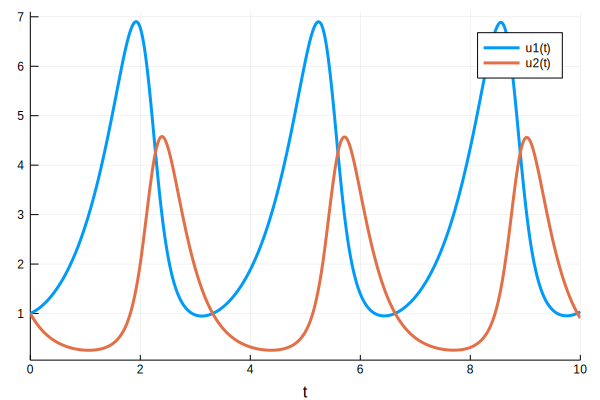

In [3]:
# To Solve the differential equations call solve on the prob
sol = solve(prob)
using Plots
plot(sol)

We can make our initial condition (u0) and time spans (tspans) to be functions of the paramters (the elements of p). For example, we can define ODEProblem:

In [4]:
u0_f(p,t0) = [p[2],p[4]]
tspan_f(p) = (0.0,10*p[4])
p = [1.5,1.0,3.0,1.0]
prob = ODEProblem(lotka_volterra,u0_f,tspan_f,p)

ODEProblem with uType typeof(u0_f) and tType Unknown. In-place: true
timespan: tspan_f
u0: u0_f

In this form, everything about the problem is determined by the paramter vector p. This will have important implications later.

## Putting ODEs into a Neural Net Framework

Note: Traditional layers are differentiable functions which take in a vector of size n and spits out a new vector size m. Differential equations solvers take in a vector p and outputs some new vector solution. 

DiffEqFlux.jl makes it easier to do this. This is the package designed specifically for this process. 

In [5]:
# Start solving an equation without gradients
p = [1.5,1.0,3.0,1.0] #parameters
prob = ODEProblem(lotka_volterra,u0,tspan,p)
sol = solve(prob,Tsit5(),saveat=0.1) # time span was 0 to 10 
A = sol[1,:]; # length 101 vector

Let's plot (t,A) over the ODE's solution to see what we got:

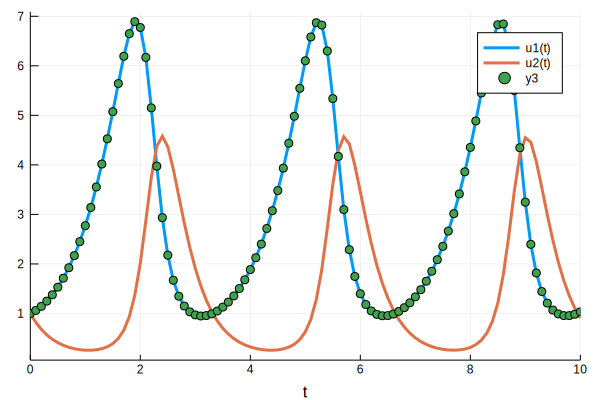

In [6]:
plot(sol)
t = 0:0.1:10.0
scatter!(t,A)

The most basic differential equation layer is diffeq_rd which does the same thing with slightly altered syntax. It takes in paramters p and outputs a solution. 

In [7]:
using Flux, DiffEqFlux
diffeq_rd(p,prob,Tsit5(),saveat=0.1)

retcode: Success
Interpolation: 1st order linear
t: 101-element Array{Float64,1}:
  0.0
  0.1
  0.2
  0.3
  0.4
  0.5
  0.6
  0.7
  0.8
  0.9
  1.0
  1.1
  1.2
  ⋮  
  8.9
  9.0
  9.1
  9.2
  9.3
  9.4
  9.5
  9.6
  9.7
  9.8
  9.9
 10.0
u: 101-element Array{Array{Float64,1},1}:
 [1.0, 1.0]         
 [1.06108, 0.821084]
 [1.14403, 0.679053]
 [1.24917, 0.566893]
 [1.37764, 0.478813]
 [1.53123, 0.410156]
 [1.71227, 0.357265]
 [1.92358, 0.317347]
 [2.16839, 0.288389]
 [2.45025, 0.269054]
 [2.77282, 0.258724]
 [3.13973, 0.257497]
 [3.5539, 0.26645]  
 ⋮                  
 [4.34617, 4.2047]  
 [3.24659, 4.54693] 
 [2.39567, 4.45777] 
 [1.81728, 4.06495] 
 [1.44276, 3.53974] 
 [1.20891, 2.99146] 
 [1.06859, 2.48207] 
 [0.991023, 2.03725]
 [0.957421, 1.66321]
 [0.956979, 1.35559]
 [0.983561, 1.10629]
 [1.03376, 0.906371]

The nice thing about diffeq_rd is that it takes care of the type handling necessary to make it compatible with the neural network framework (in this case flux).

We are going to define a neural network with the function as our single layer and then a loss function that is the squared distance of the output values from 1.

In [8]:
p = param([2.2, 1.0, 2.0, 0.4]) # Initial Parameter Vector
params = Flux.Params([p])

function predict_rd() # Our 1-layer neural network
  diffeq_rd(p,prob,Tsit5(),saveat=0.1)[1,:]
end

#true_vect = sin.(t) .+ 1

loss_rd() = sum(abs2,x-1 for x in predict_rd()) # loss function
#loss_rd() = sum(abs2,predict_rd()-true_vect) # loss function

loss_rd (generic function with 1 method)

Now we tell Flux to train the neural network by running 100 iterations to minimize our loss function(loss_rd()) and getting the optimal parameters:

4314.862717067556 (tracked)

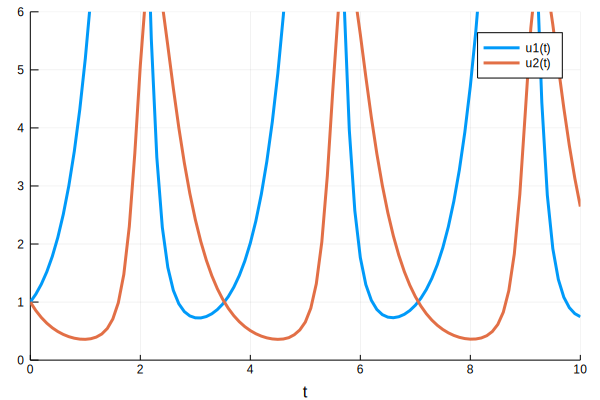

1990.4387436670527 (tracked)

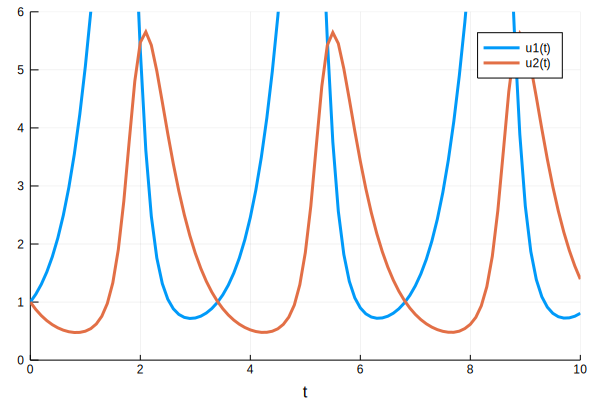

1042.6099582225459 (tracked)

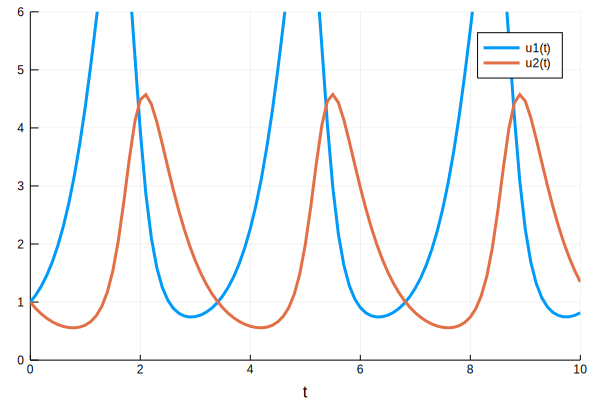

588.8091720988157 (tracked)

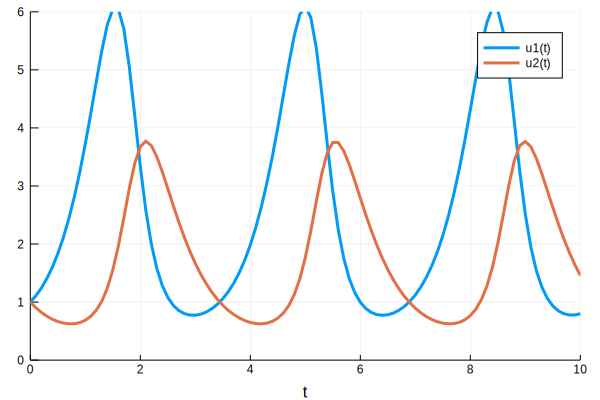

348.673609066376 (tracked)

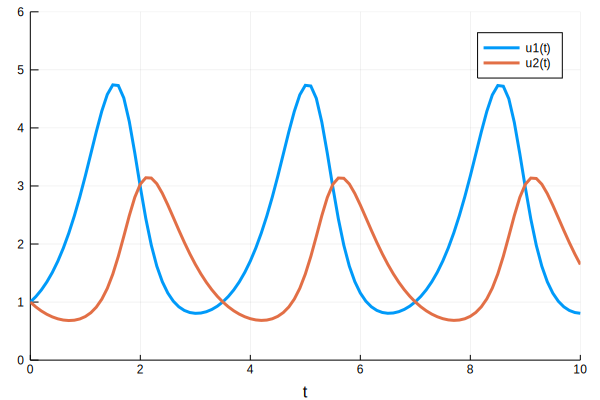

212.09210264430453 (tracked)

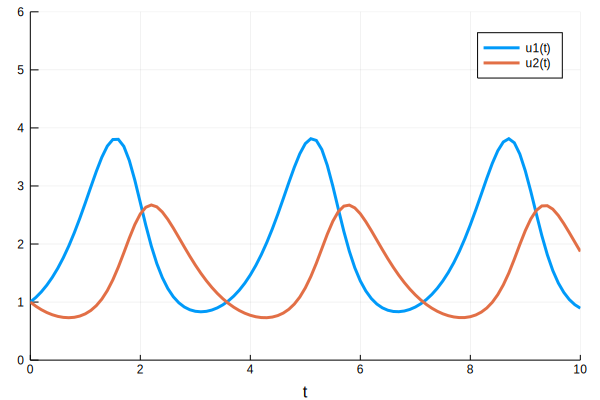

129.80630155180214 (tracked)

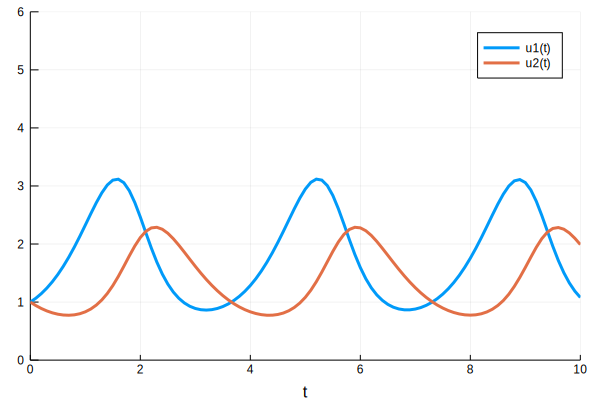

78.87975707156943 (tracked)

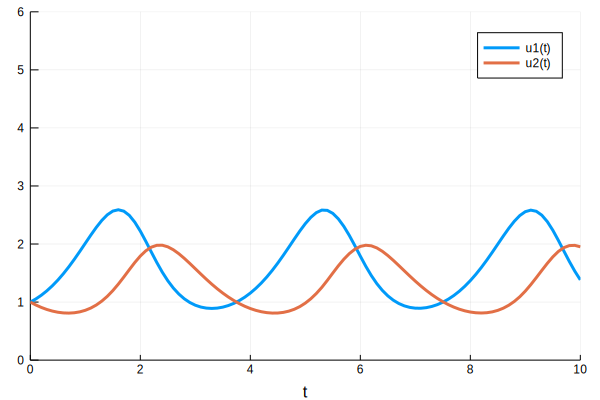

46.29195540443252 (tracked)

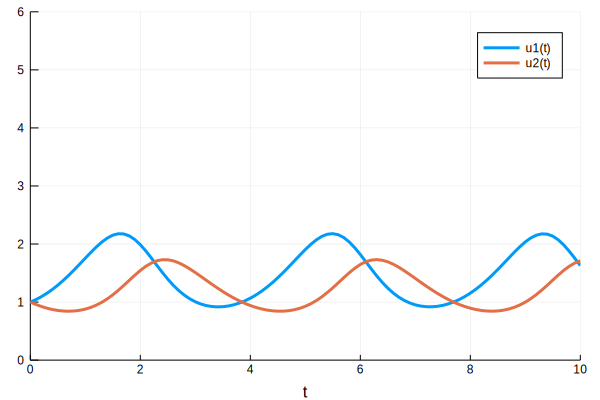

25.154691296963183 (tracked)

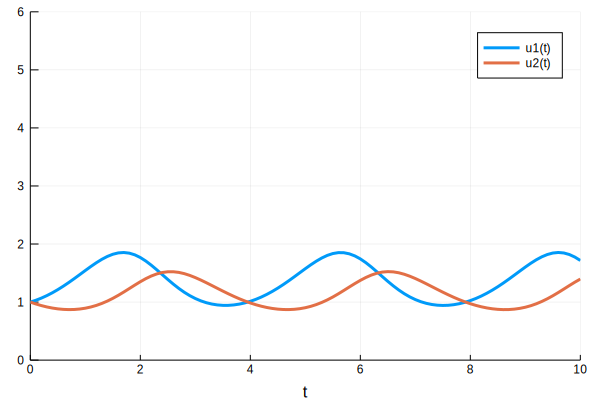

12.140053627292993 (tracked)

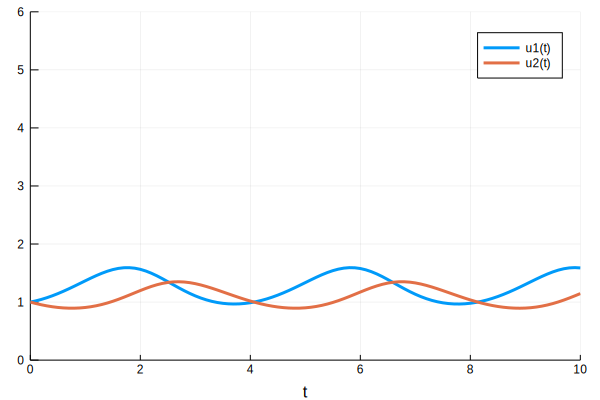

4.985544449929382 (tracked)

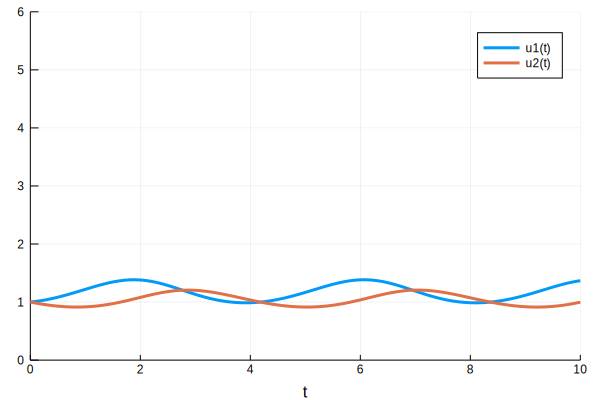

1.6123253046064934 (tracked)

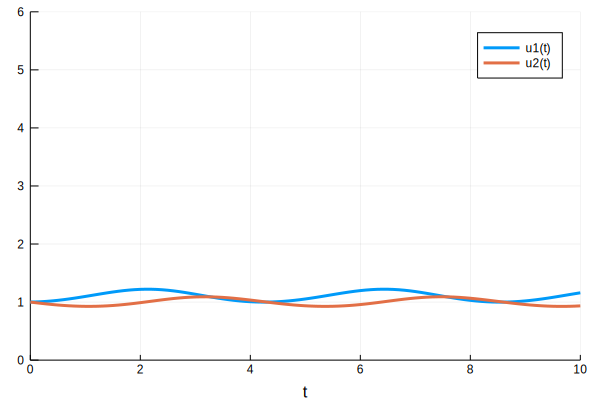

0.4084406311702526 (tracked)

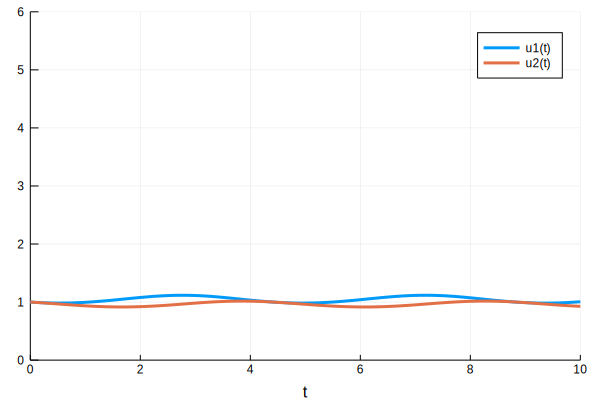

0.40742170275689893 (tracked)

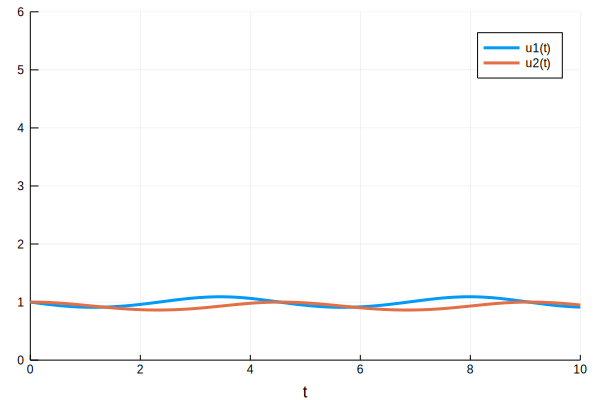

1.0997810492688838 (tracked)

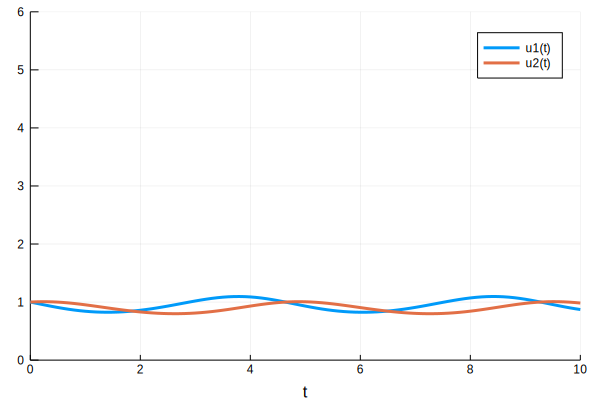

2.217538646012819 (tracked)

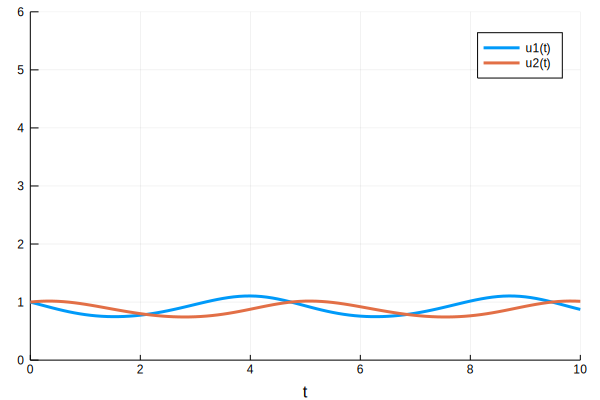

3.6001922494449805 (tracked)

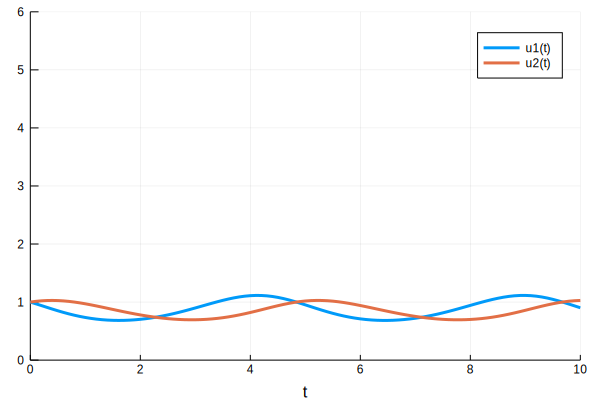

5.130520045600731 (tracked)

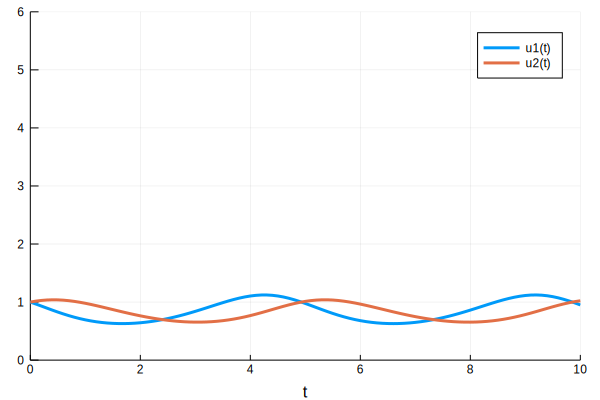

6.709933635849061 (tracked)

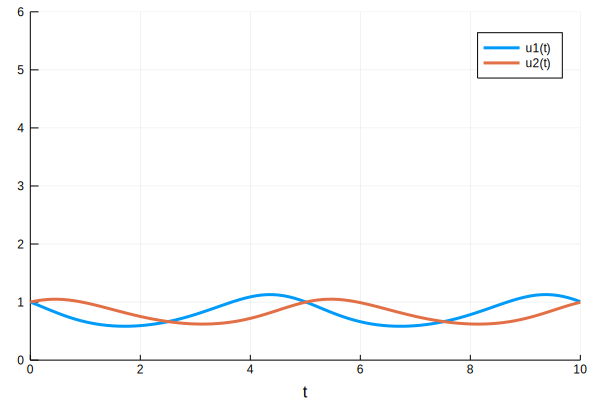

8.256654898522717 (tracked)

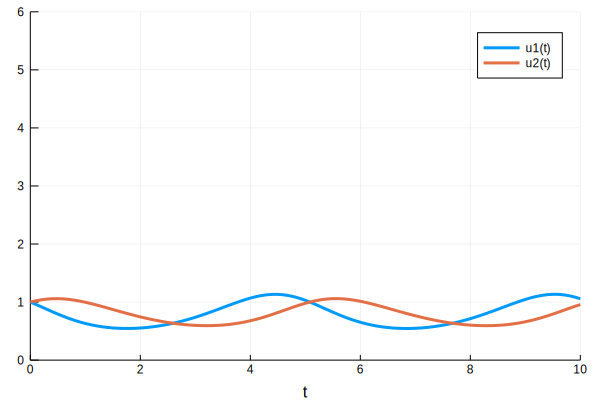

9.712155961768008 (tracked)

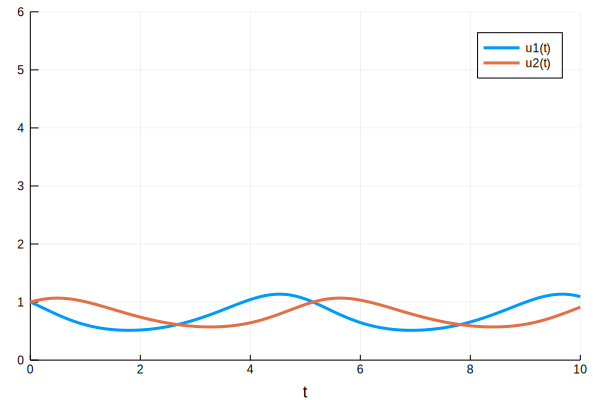

11.041816363858722 (tracked)

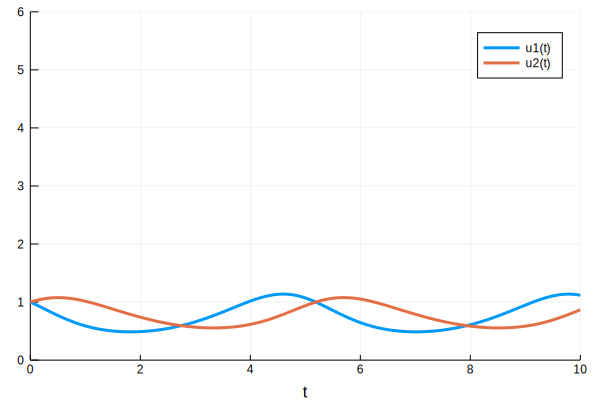

12.2197608796972 (tracked)

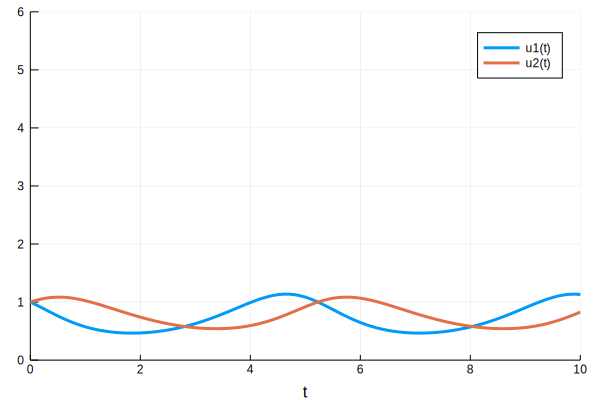

13.24058969870178 (tracked)

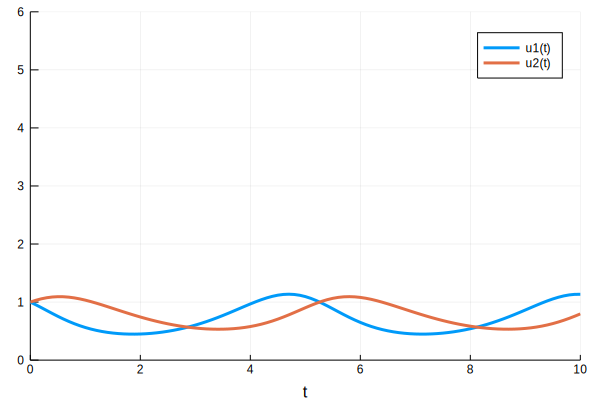

14.099175380729129 (tracked)

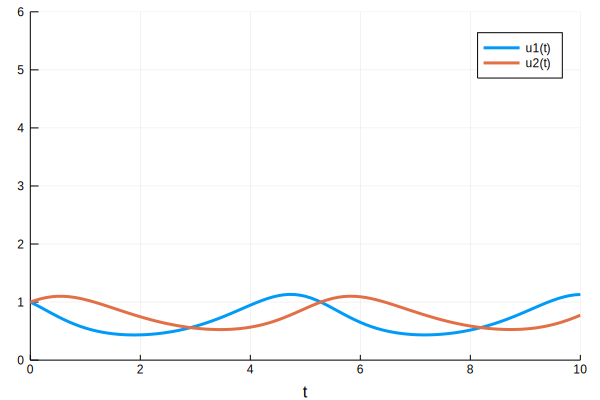

14.796600311389977 (tracked)

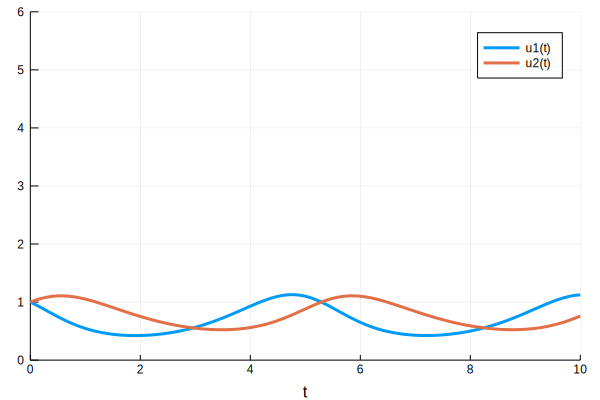

15.336796649216762 (tracked)

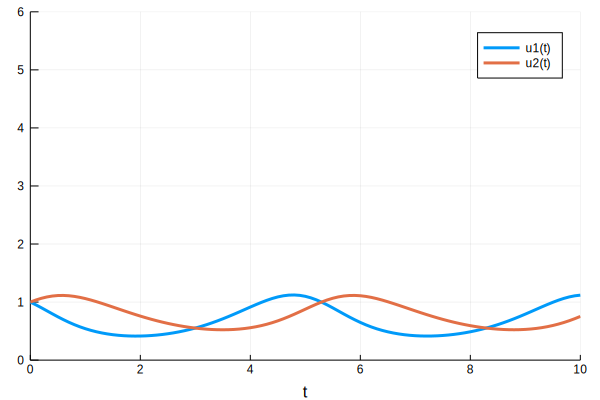

15.726794388648969 (tracked)

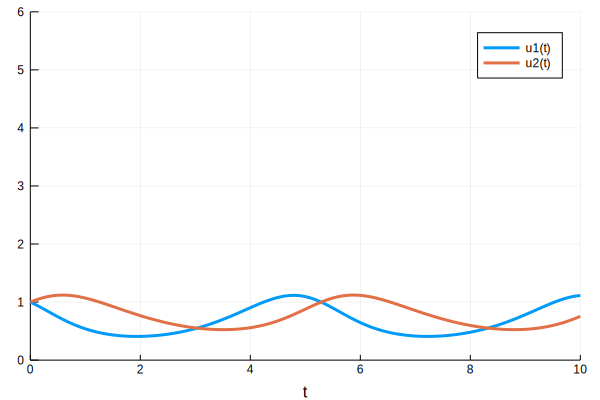

15.977365021371316 (tracked)

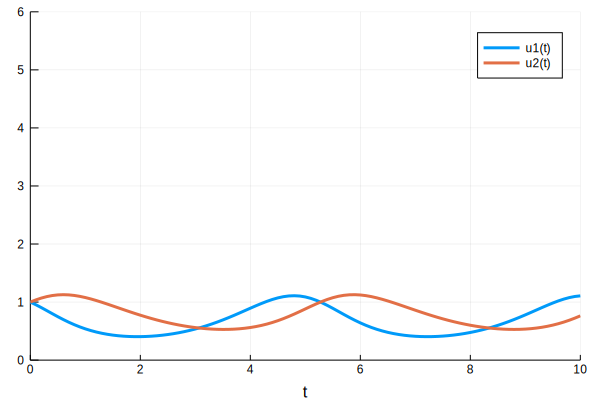

16.099193064201614 (tracked)

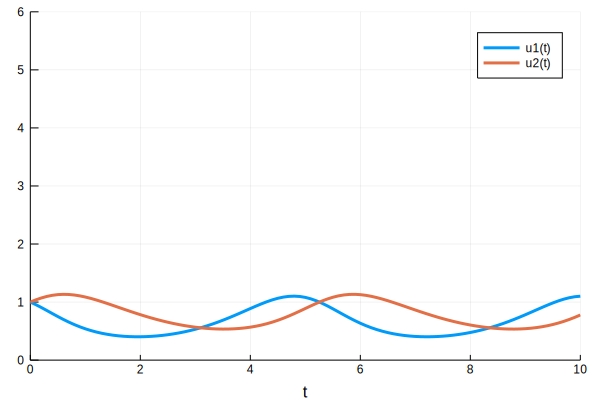

16.105007713065284 (tracked)

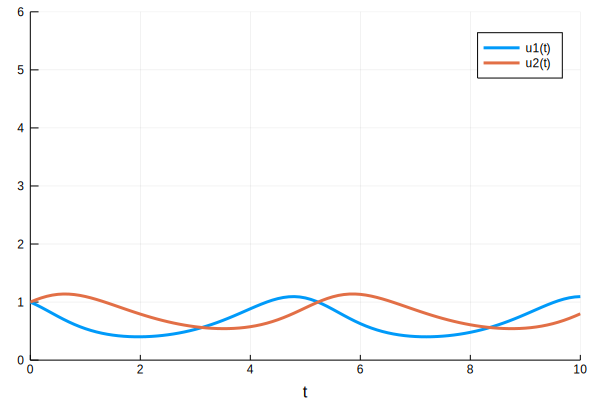

16.00802717752825 (tracked)

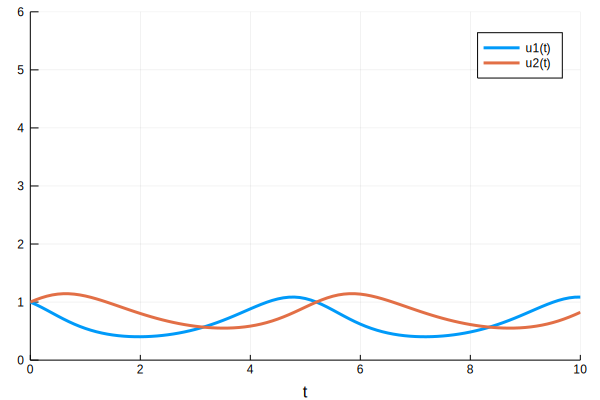

15.821735952173817 (tracked)

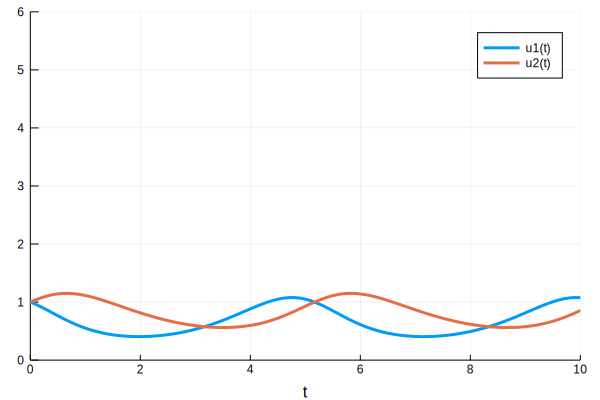

15.559457803457022 (tracked)

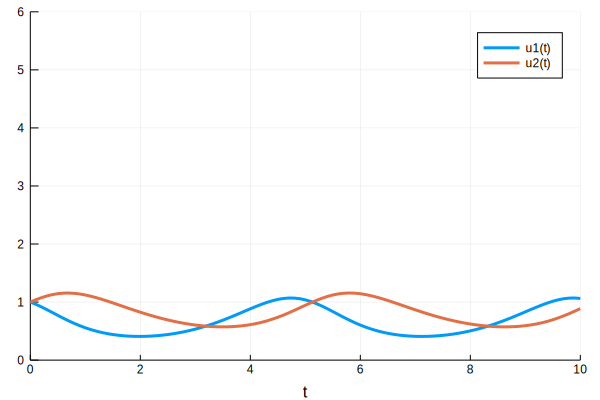

15.233924904874756 (tracked)

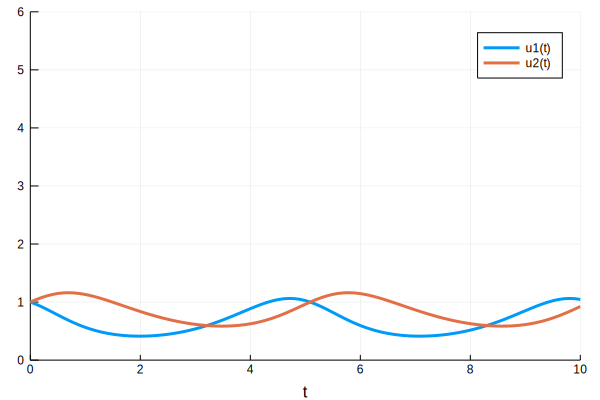

14.856896624120585 (tracked)

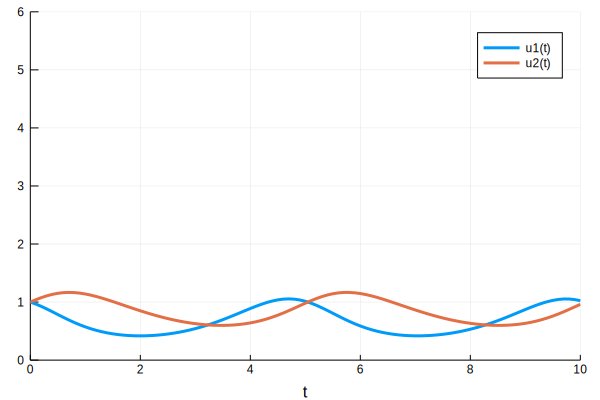

14.44157670033084 (tracked)

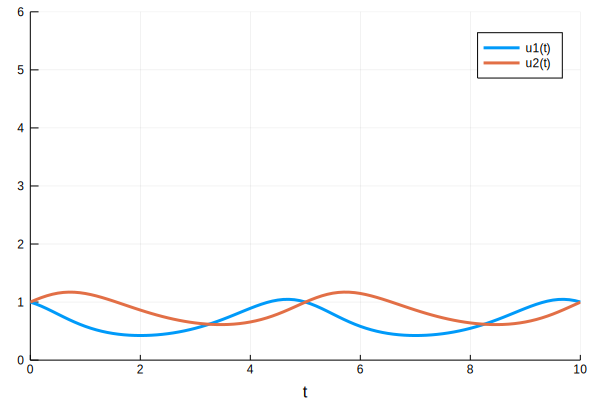

13.997181182048964 (tracked)

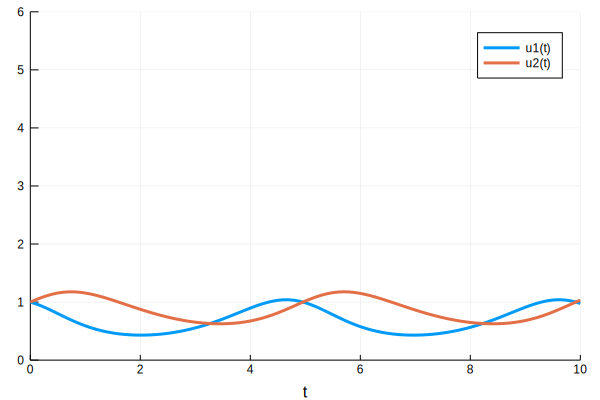

13.53426601303803 (tracked)

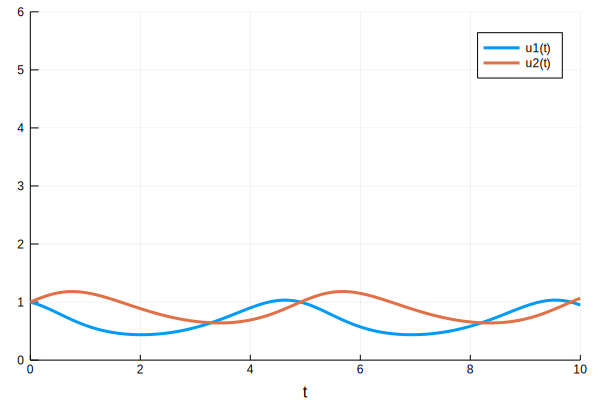

13.061797307320871 (tracked)

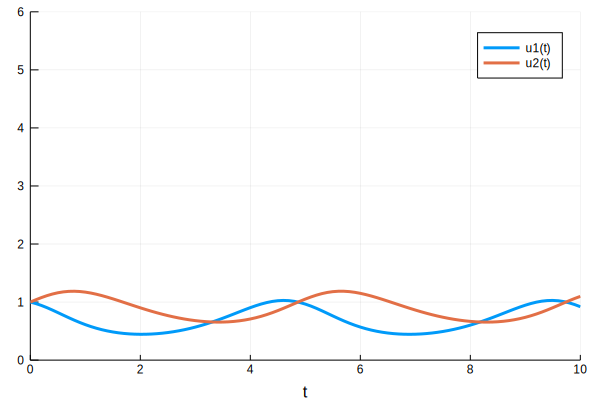

12.586669793991707 (tracked)

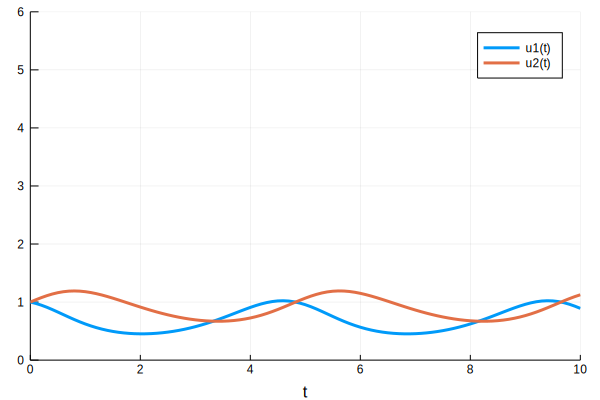

12.116787272098813 (tracked)

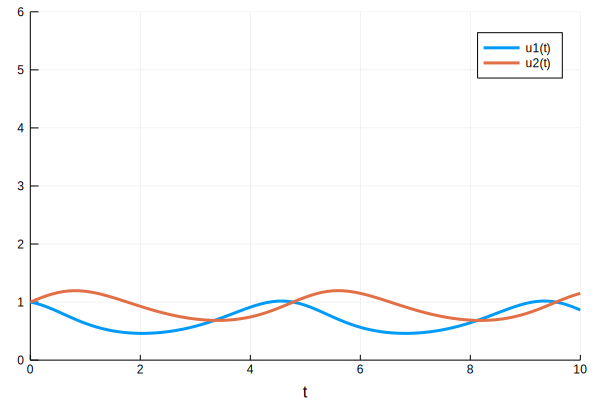

11.655139868448 (tracked)

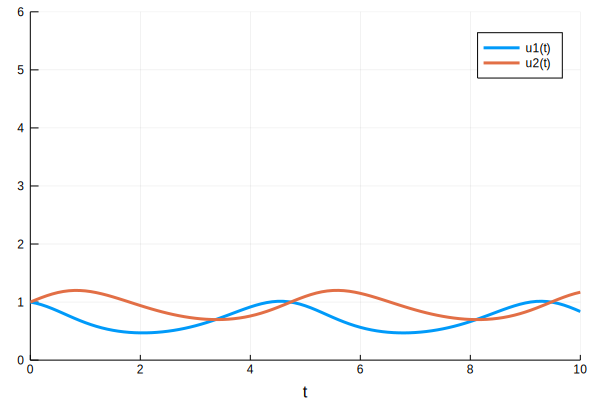

11.205241892246873 (tracked)

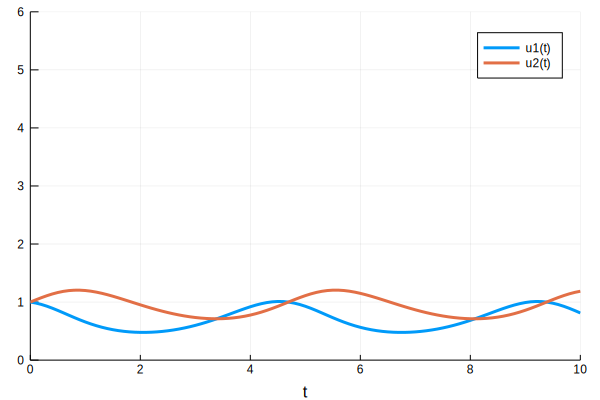

10.768926401677778 (tracked)

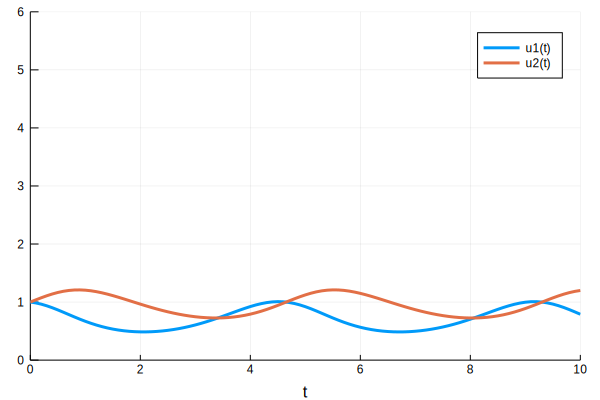

10.3477864386573 (tracked)

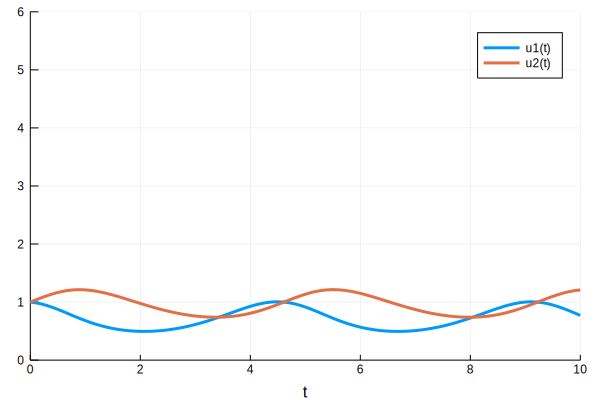

9.942695725651395 (tracked)

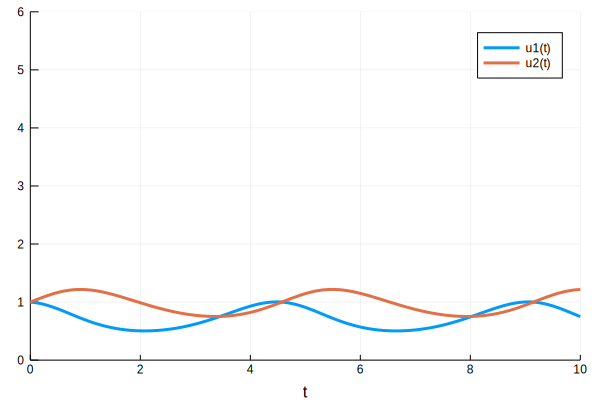

9.5529861203755 (tracked)

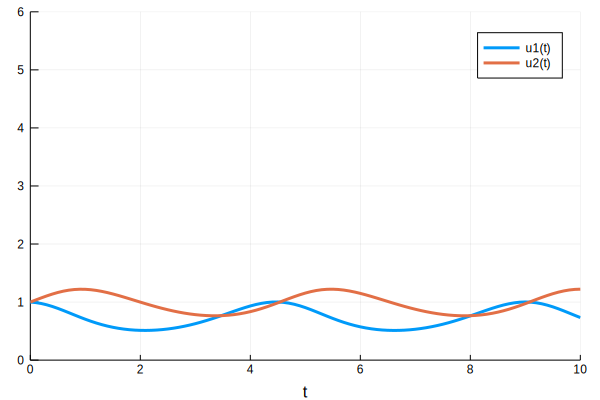

9.177646362931252 (tracked)

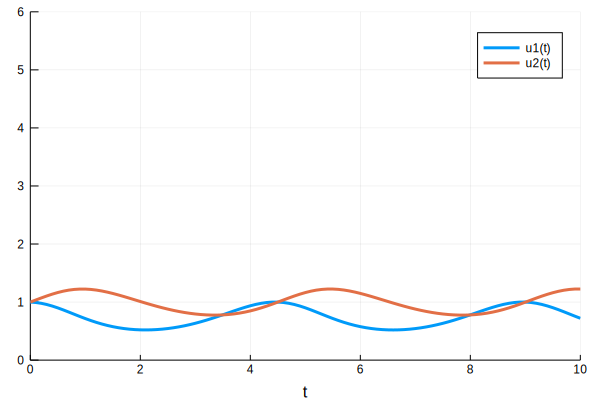

8.816244503124098 (tracked)

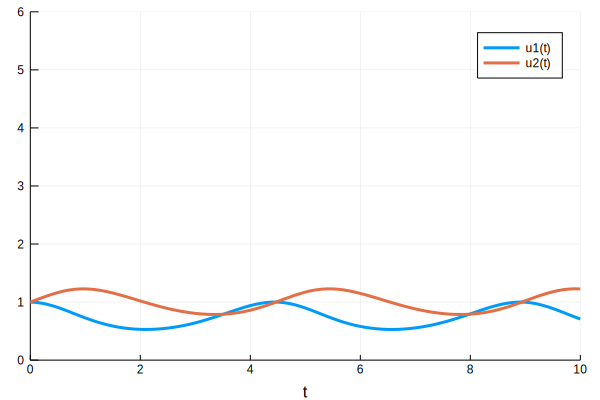

8.468275262444028 (tracked)

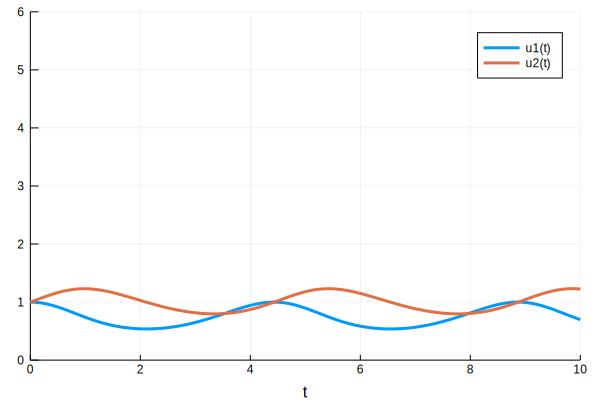

8.131897817300901 (tracked)

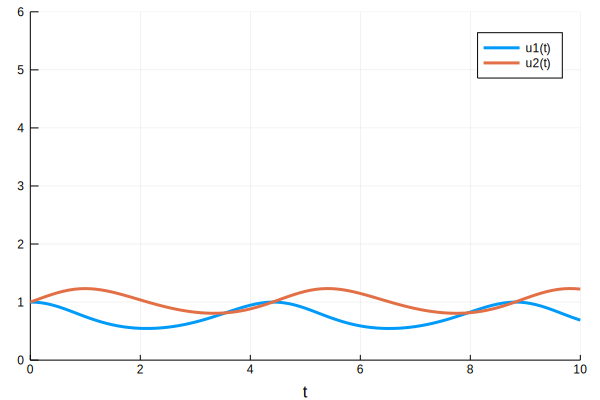

7.807245850197258 (tracked)

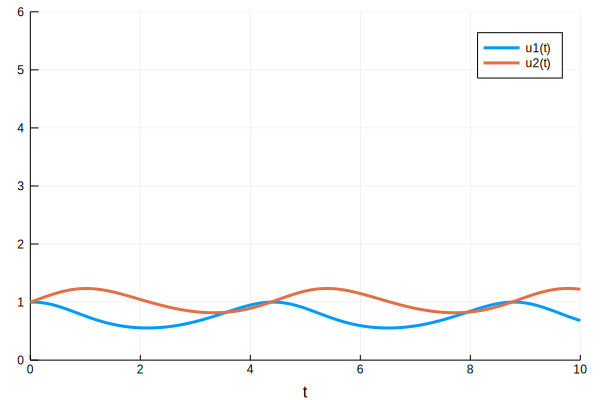

7.493004611194964 (tracked)

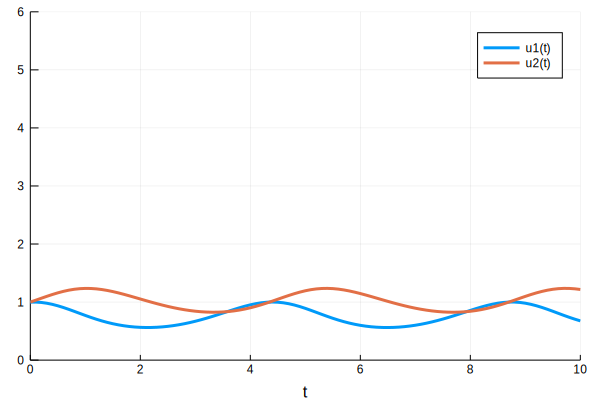

7.188392479444747 (tracked)

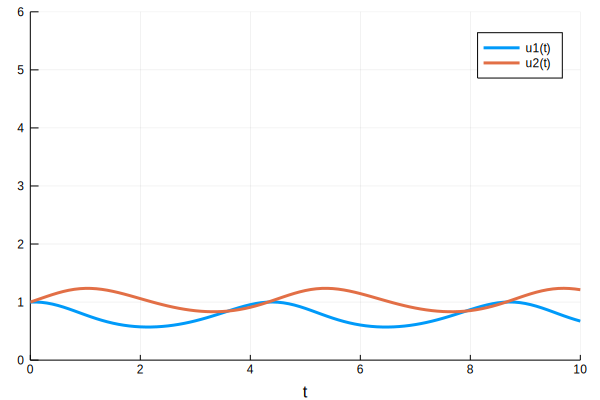

6.8927661281878985 (tracked)

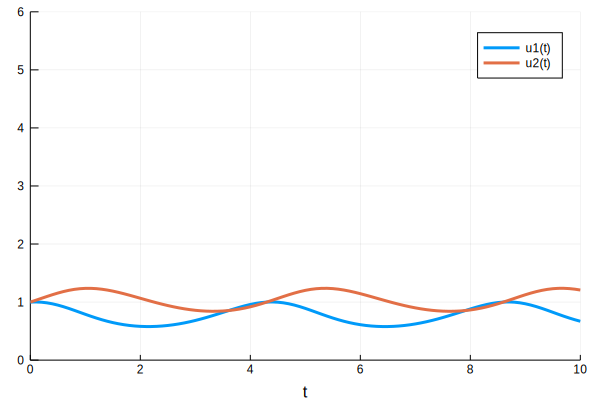

6.605504370469788 (tracked)

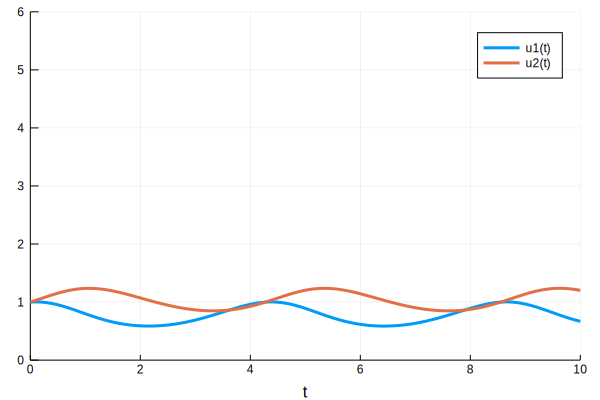

6.3264205639625475 (tracked)

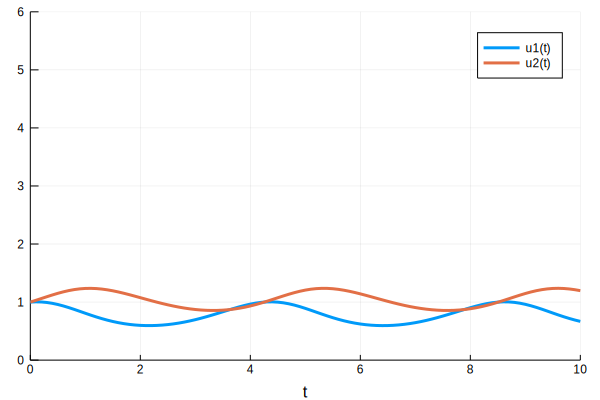

6.052982003953798 (tracked)

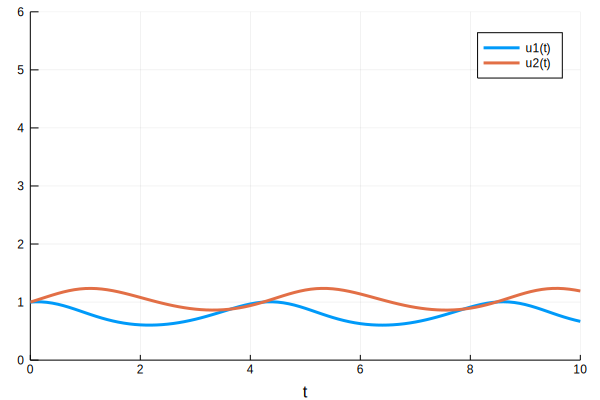

5.78725730008782 (tracked)

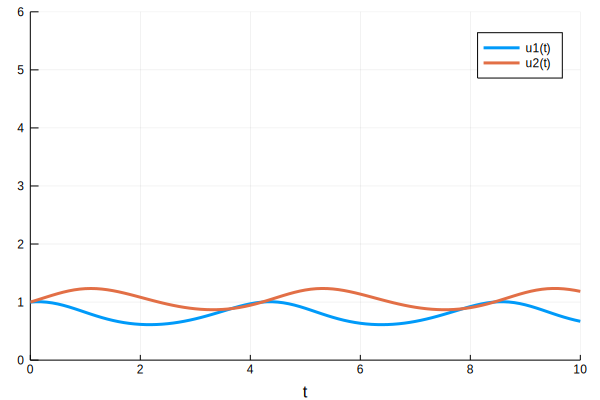

5.528132775256903 (tracked)

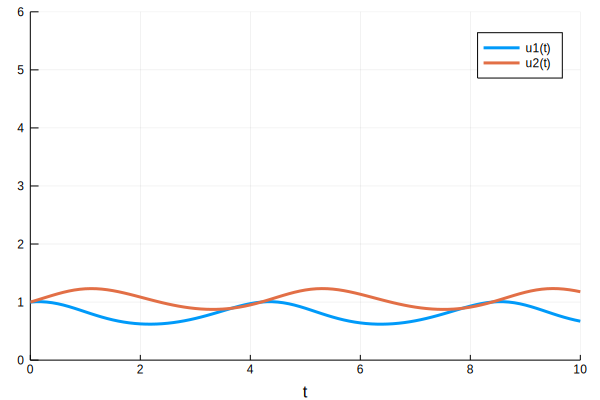

5.275181546545231 (tracked)

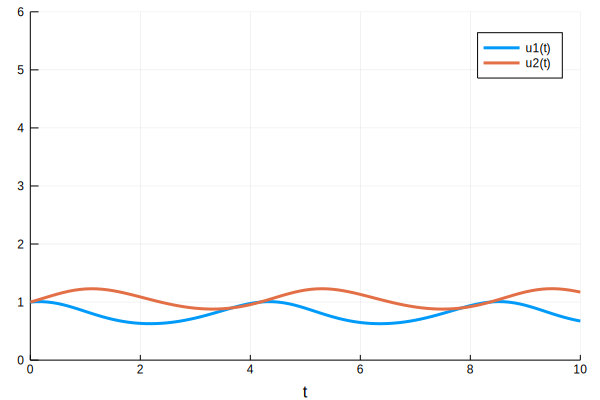

5.028229886823649 (tracked)

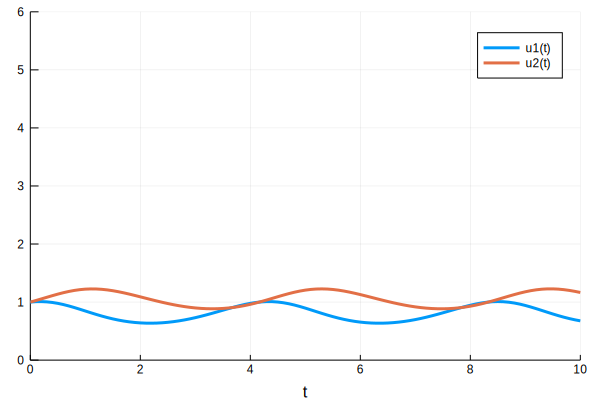

4.78716746520905 (tracked)

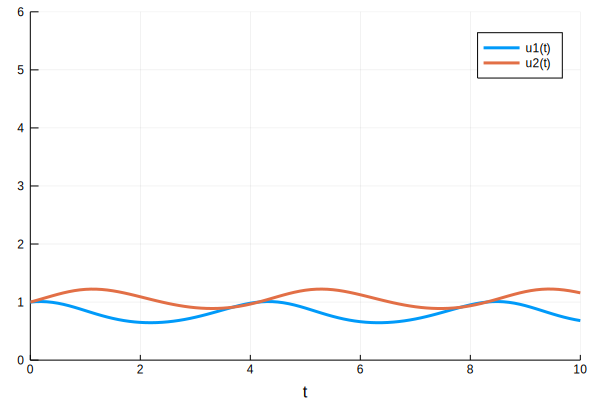

4.551934697070294 (tracked)

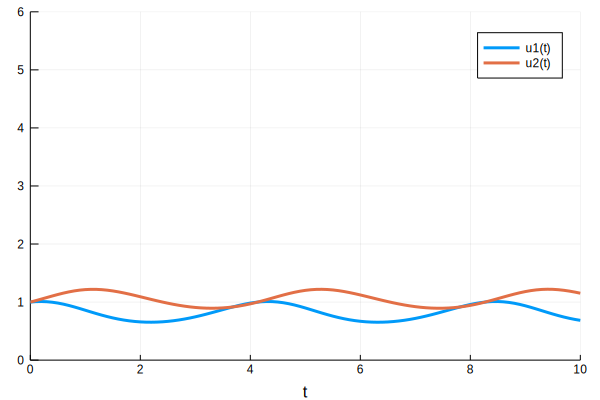

4.322521113938008 (tracked)

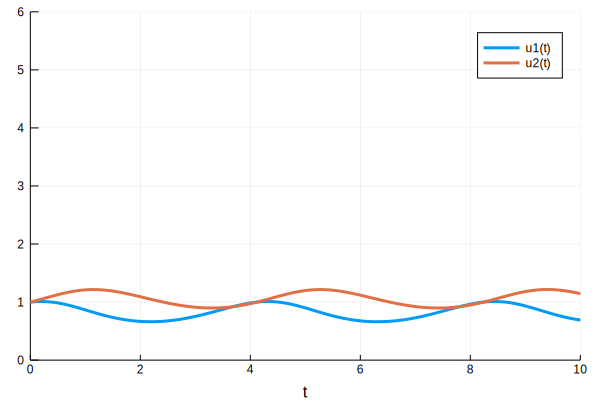

4.098956675631279 (tracked)

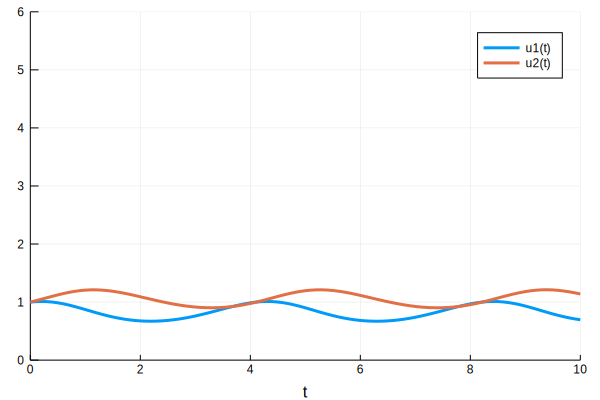

3.8813054074193047 (tracked)

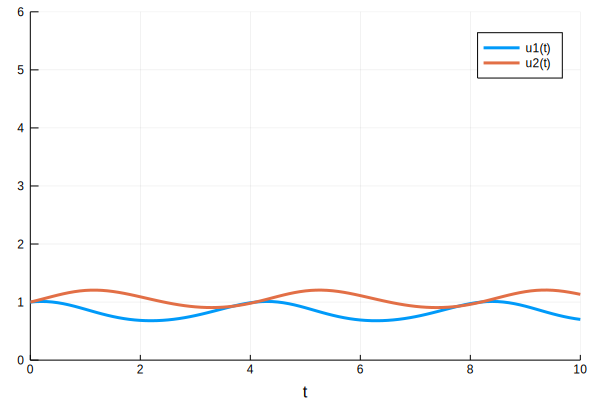

3.6696586344792537 (tracked)

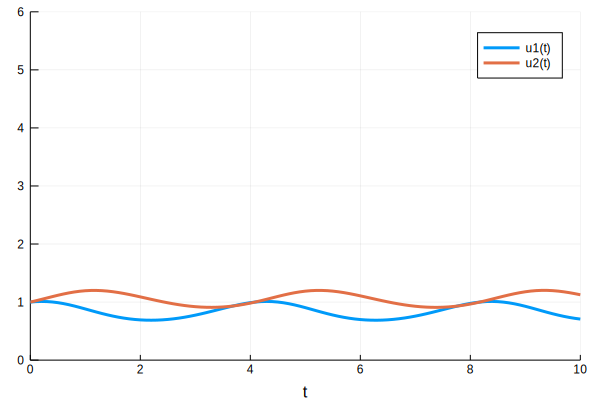

3.4641278524045562 (tracked)

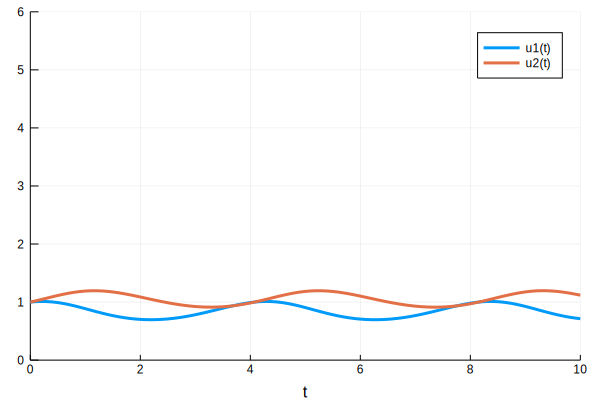

3.2648377149137042 (tracked)

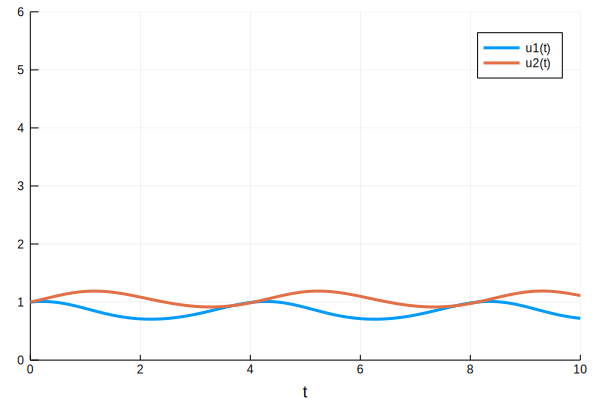

3.0719179339042353 (tracked)

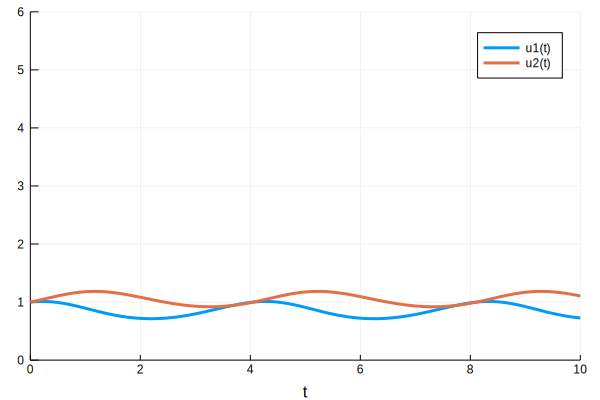

2.885496627827426 (tracked)

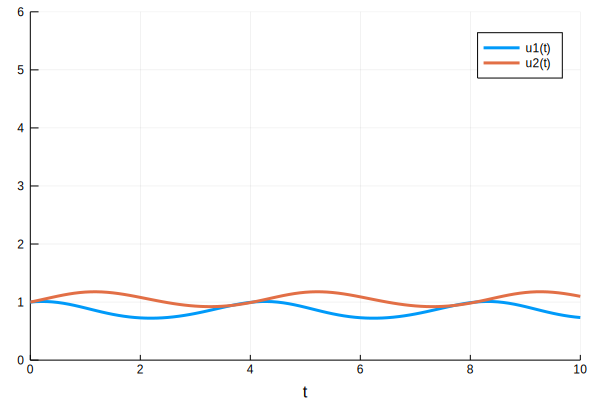

2.7056972513827593 (tracked)

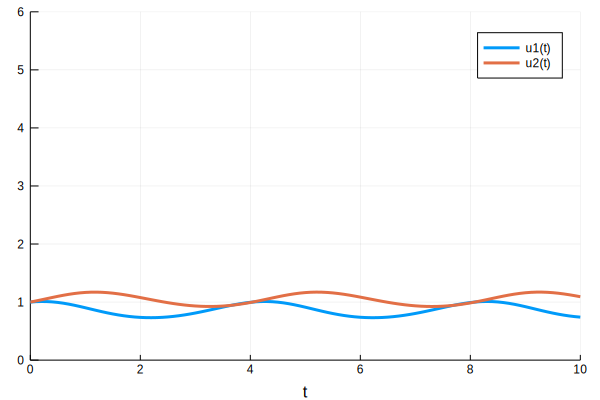

2.532633445158044 (tracked)

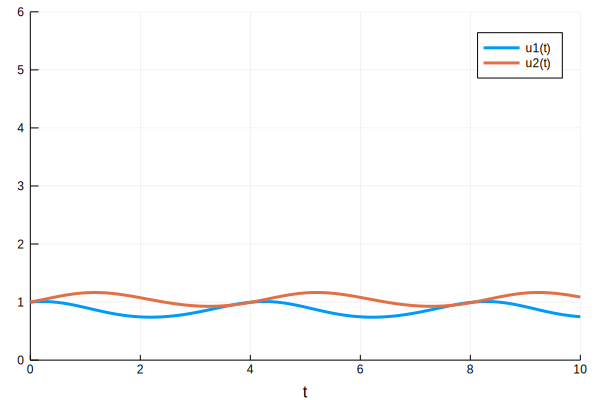

2.3664331983627753 (tracked)

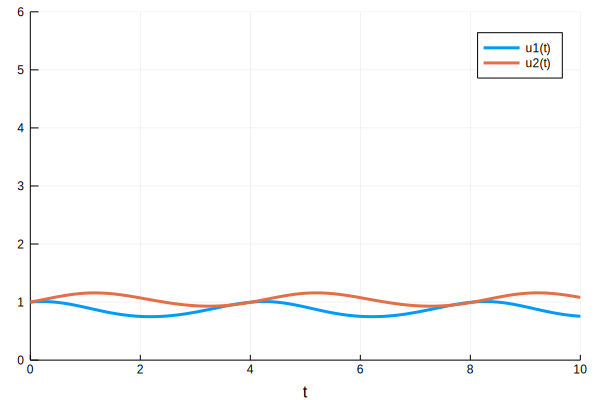

2.2069866638079483 (tracked)

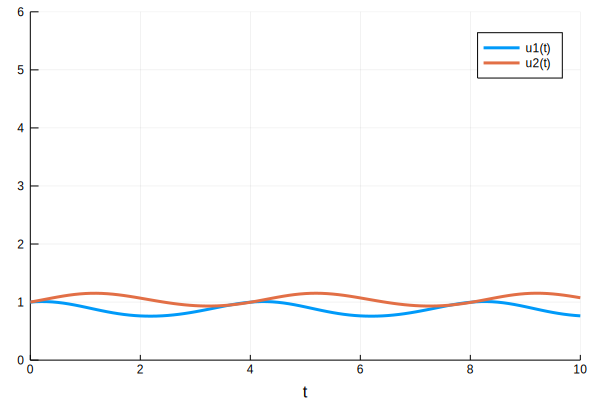

2.0544992249562273 (tracked)

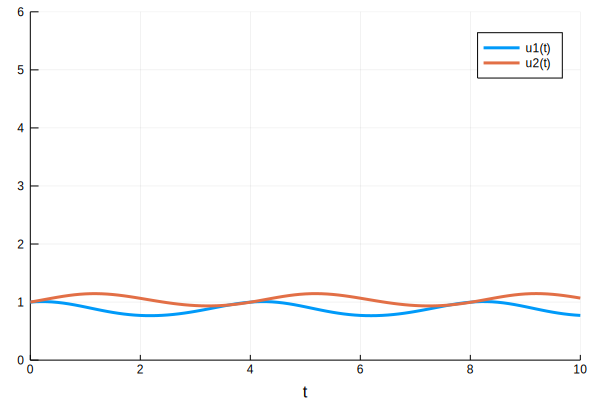

1.9092261131236448 (tracked)

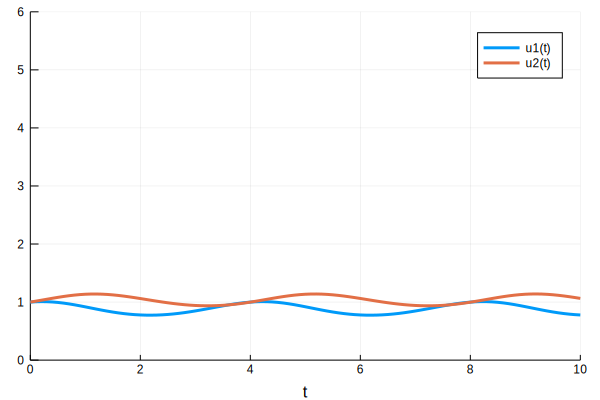

1.7704498157809687 (tracked)

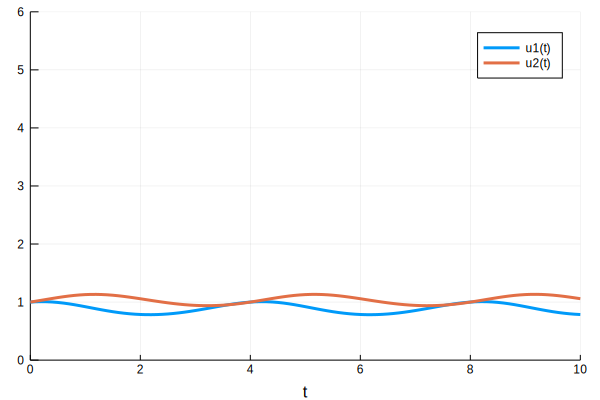

1.638539920030971 (tracked)

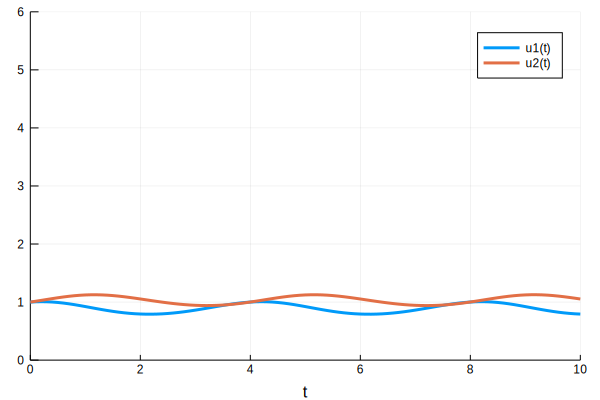

1.5136165964382038 (tracked)

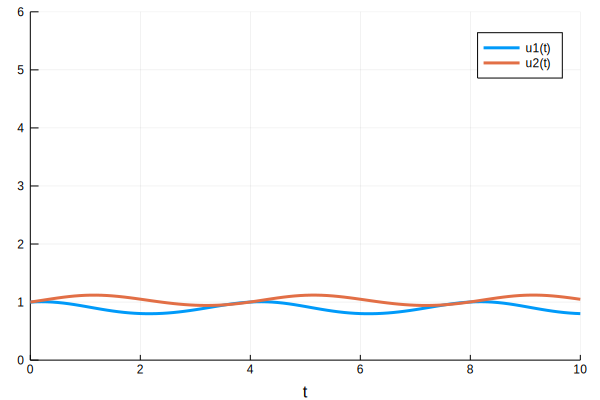

1.3955083255942693 (tracked)

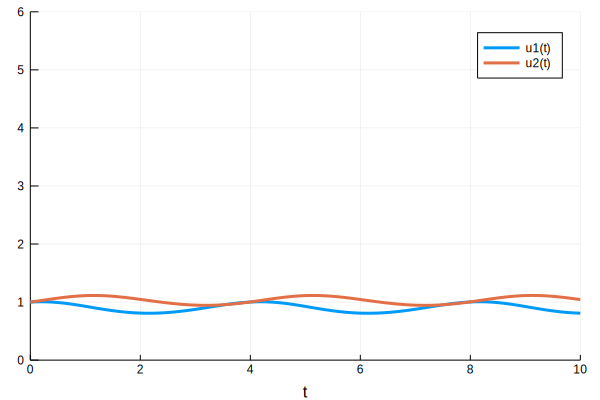

1.2839415349274836 (tracked)

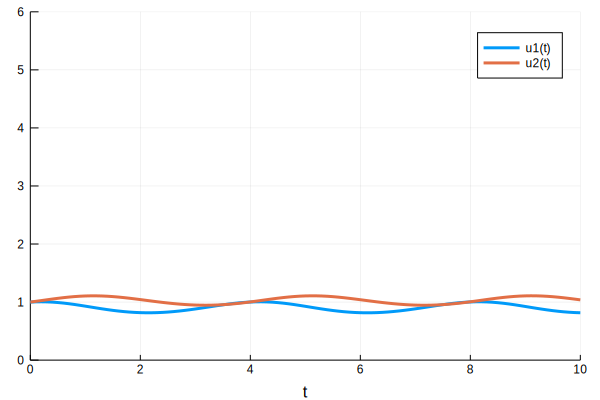

1.1788316569409218 (tracked)

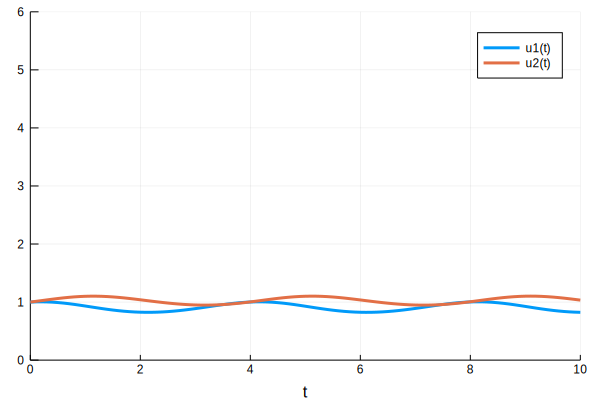

1.0800663681594482 (tracked)

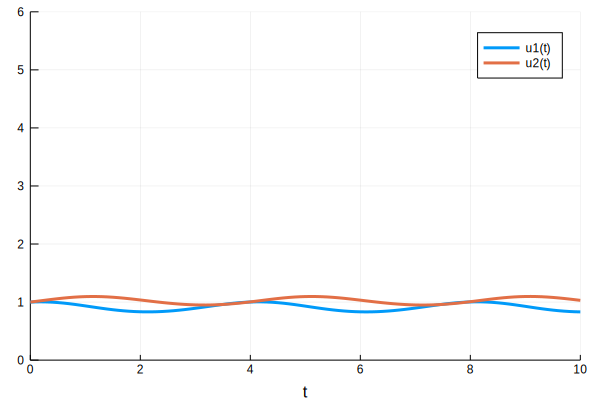

0.9875747254592804 (tracked)

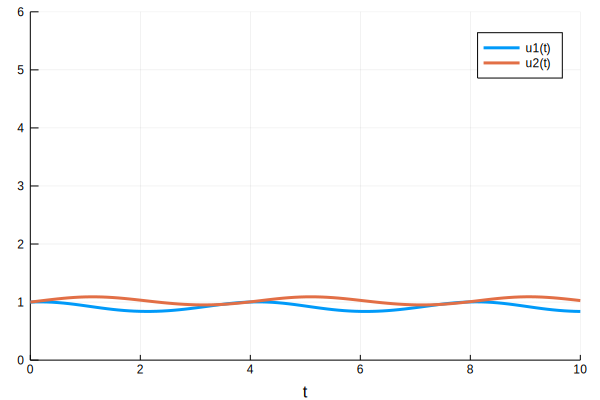

0.9009326556904098 (tracked)

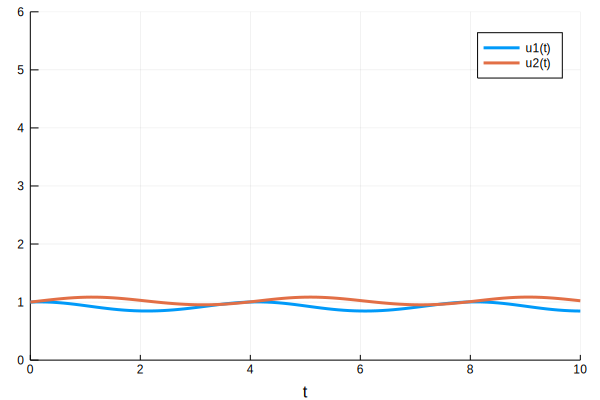

0.8200152183308191 (tracked)

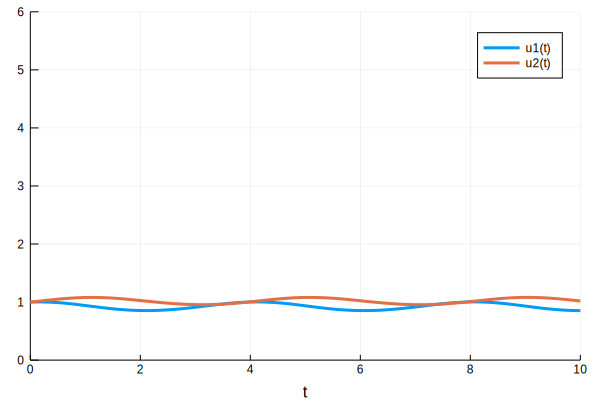

0.7447454849774922 (tracked)

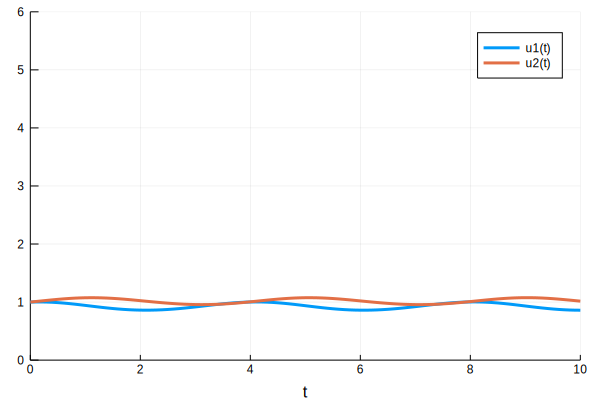

0.6744669249531177 (tracked)

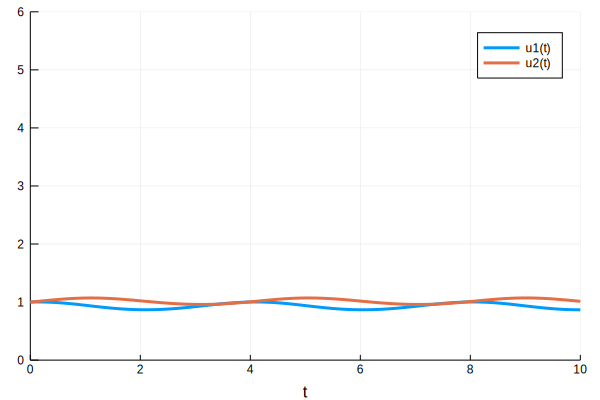

0.6093022380586467 (tracked)

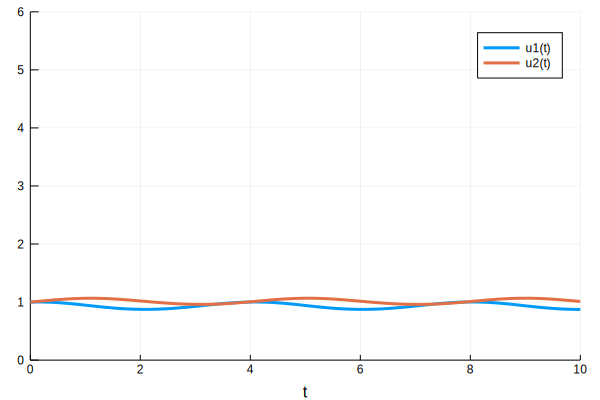

0.549018246299879 (tracked)

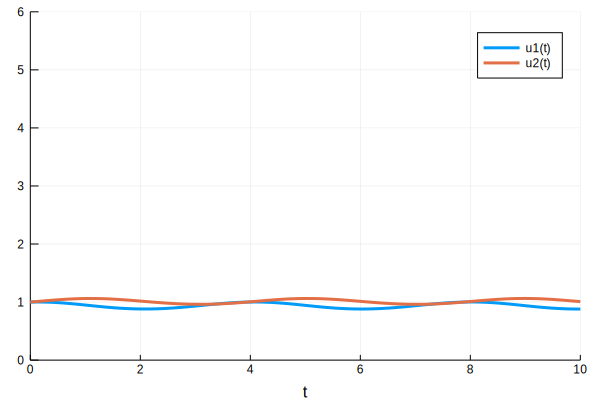

0.493351937332953 (tracked)

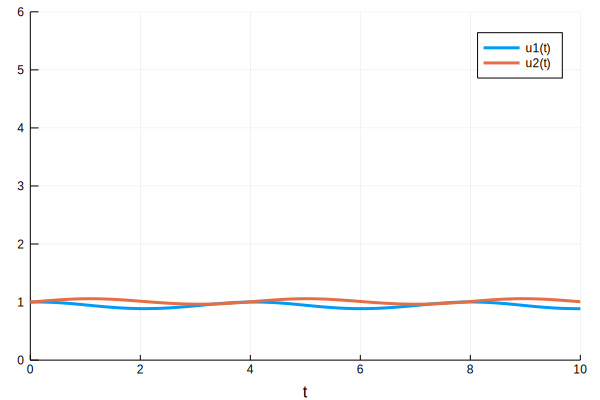

0.44207586642001767 (tracked)

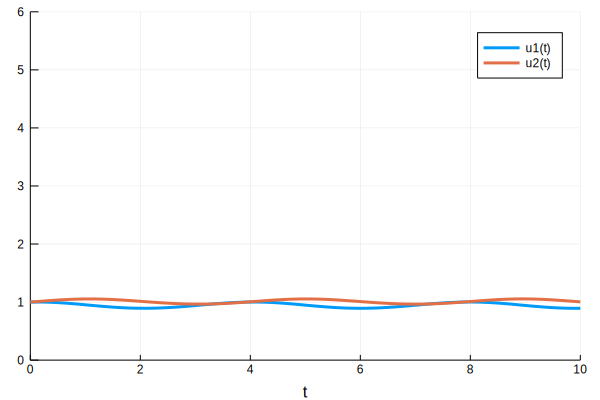

0.39495402719744105 (tracked)

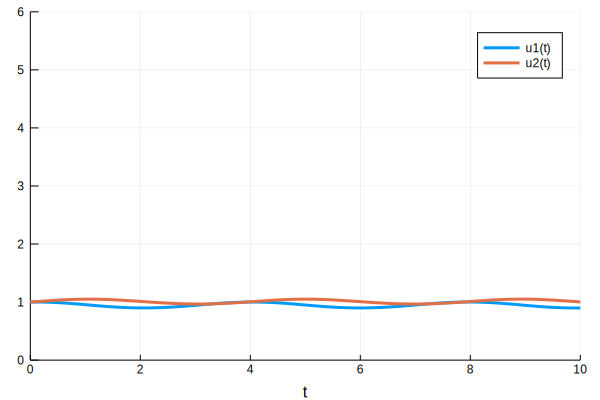

0.35176015547039113 (tracked)

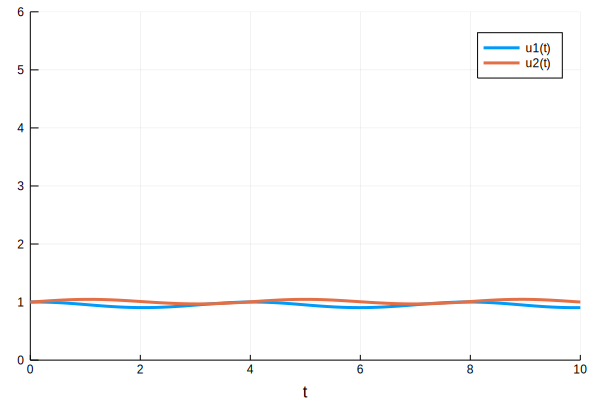

0.3123050864876163 (tracked)

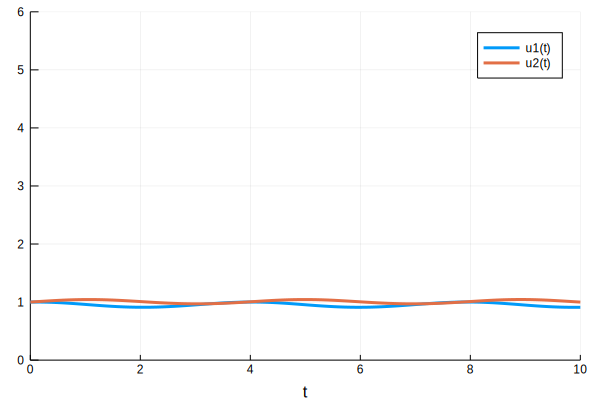

0.2762466522245909 (tracked)

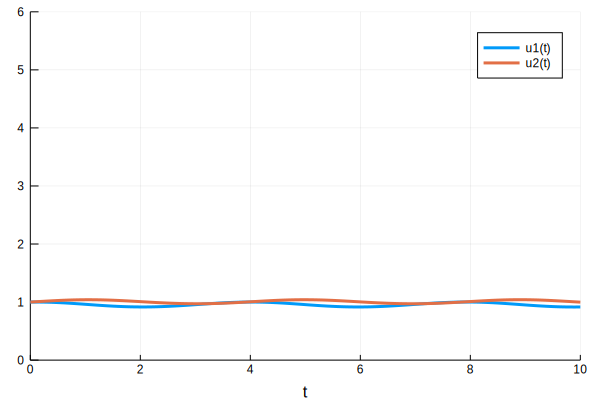

0.24342223619991304 (tracked)

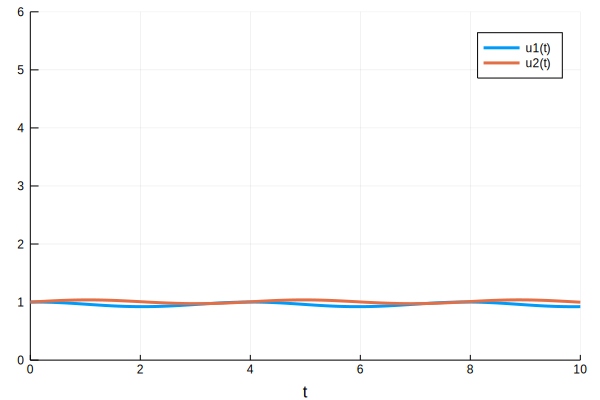

In [9]:
data = Iterators.repeated((), 100)
opt = ADAM(0.1)
cb = function () #callback function to observe training
  display(loss_rd())
  # using `remake` to re-create our `prob` with current parameters `p`
  display(plot(solve(remake(prob,p=Flux.data(p)),Tsit5(),saveat=0.1),ylim=(0,6)))
end

# Display the ODE with the initial parameter values.
cb()

Flux.train!(loss_rd, params, data, opt, cb = cb)

Flux finds the paramters of the neural network(p) which minimize the cost function. 

Note: The forward pass of the neural network includes solving an ODE.

We can then have solving ODEs as just a layer we can add it anywhere. For example if we take the multilayer perceptron written in Flux as 

In [ ]:
m = Chain(
    Dense(28^2,32, relu), # 784 -> 32
    Dense(32,10),# 32-->10
    softmax
)

If we had an ODE that took in the correct size of paramter vector then we can incorporate it into the network

In [10]:
m = Chain(
  Dense(28^2, 32, relu),
  # this would require an ODE of 32 parameters
  p -> diffeq_rd(p,prob,Tsit5(),saveat=0.1)[1,:],
  Dense(32, 10),
  softmax)

Chain(Dense(784, 32, NNlib.relu), getfield(Main, Symbol("##7#8"))(), Dense(32, 10), NNlib.softmax)

or it can be used in a covolutional network where the previous layers define the initial condition of the ODE:

In [11]:
m = Chain(
  Conv((2,2), 1=>16, relu),
  x -> maxpool(x, (2,2)),
  Conv((2,2), 16=>8, relu),
  x -> maxpool(x, (2,2)),
  x -> reshape(x, :, size(x, 4)),
  x -> diffeq_rd(p,prob,Tsit5(),saveat=0.1,u0=x)[1,:],
  Dense(288, 10), softmax) |> gpu

Chain(Conv((2, 2), 1=>16, NNlib.relu), getfield(Main, Symbol("##9#13"))(), Conv((2, 2), 16=>8, NNlib.relu), getfield(Main, Symbol("##10#14"))(), getfield(Main, Symbol("##11#15"))(), getfield(Main, Symbol("##12#16"))(), Dense(288, 10), NNlib.softmax)

You can even use stochastic differential equations

4151.214820420018 (tracked)

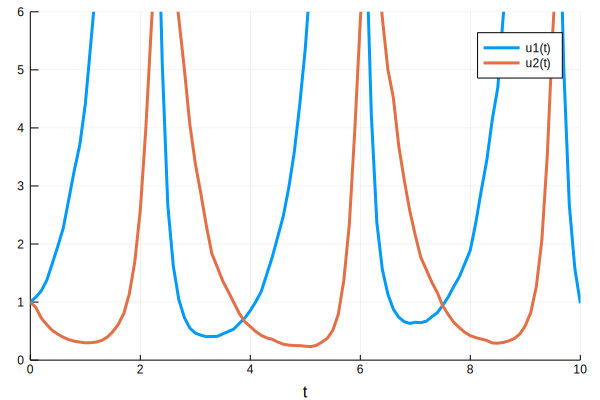

1674.372212345358 (tracked)

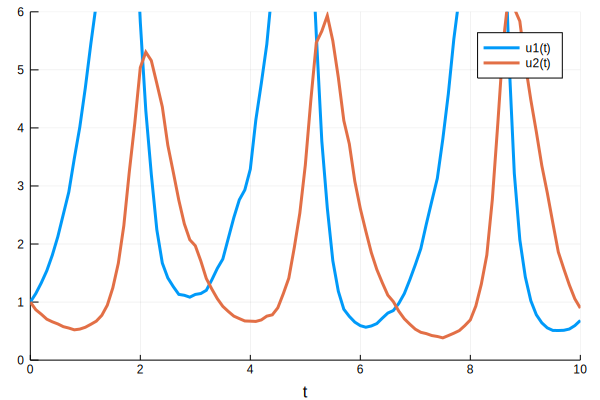

1460.8884091429104 (tracked)

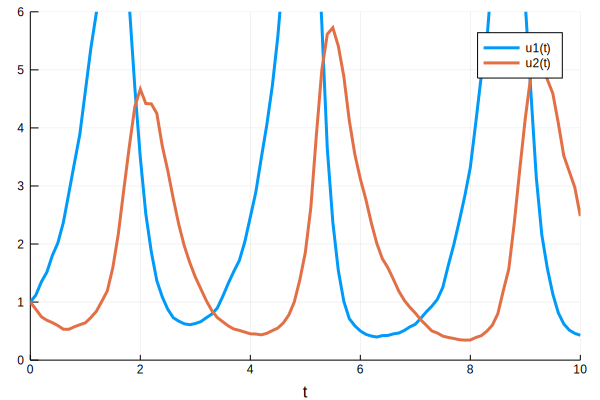

922.8027152783424 (tracked)

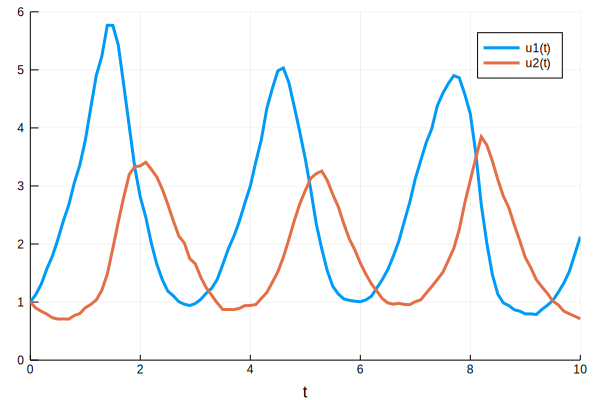

294.17898810343064 (tracked)

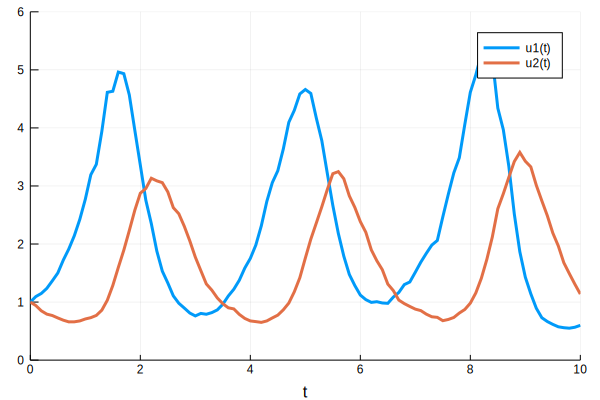

227.18160643631117 (tracked)

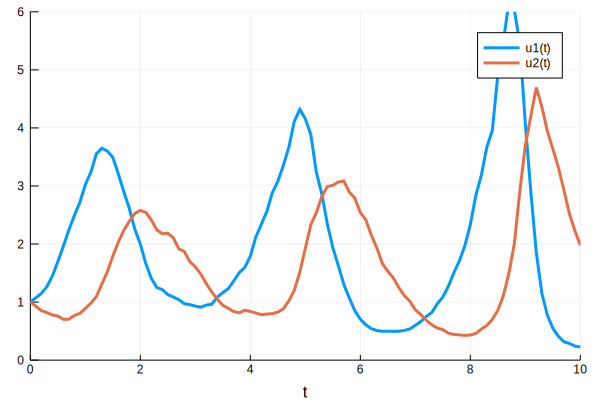

176.14570306898156 (tracked)

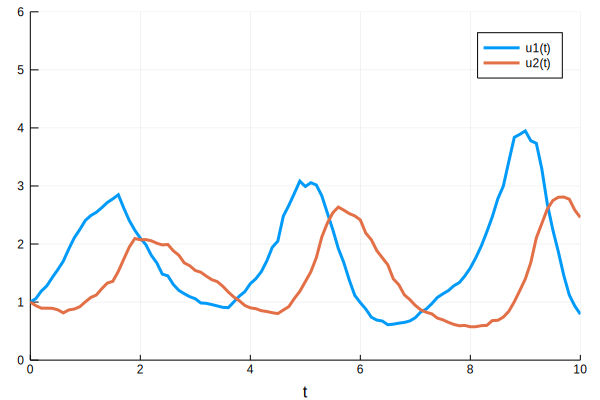

88.31338719415875 (tracked)

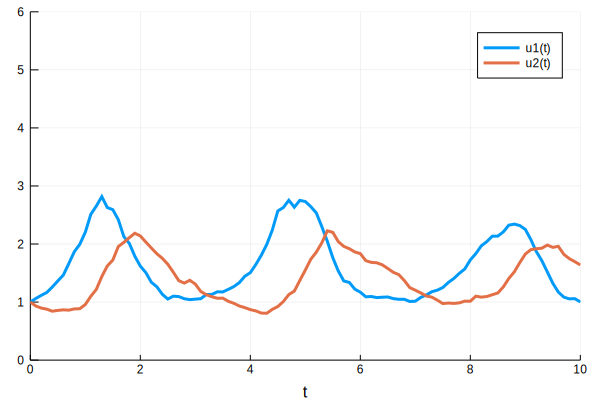

37.818037333918674 (tracked)

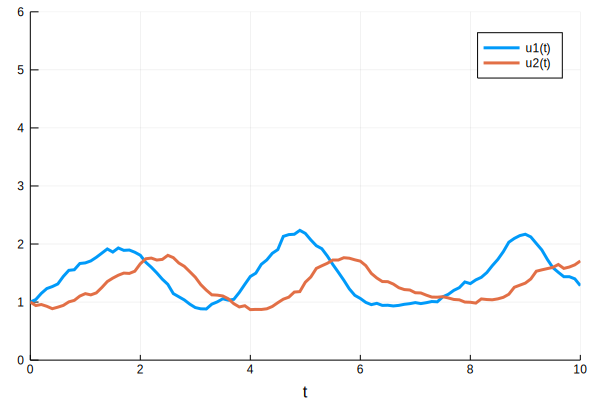

77.16150100520949 (tracked)

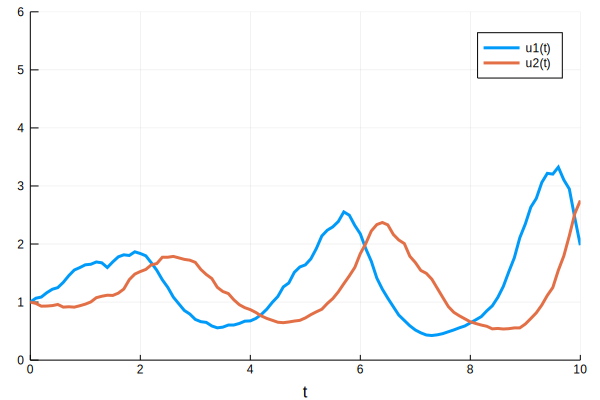

13.740257551116382 (tracked)

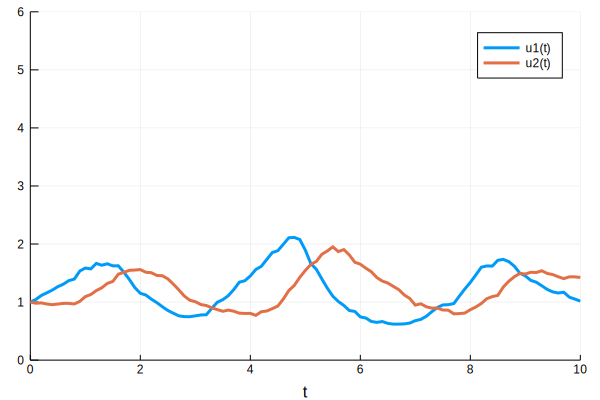

3.0914129309659892 (tracked)

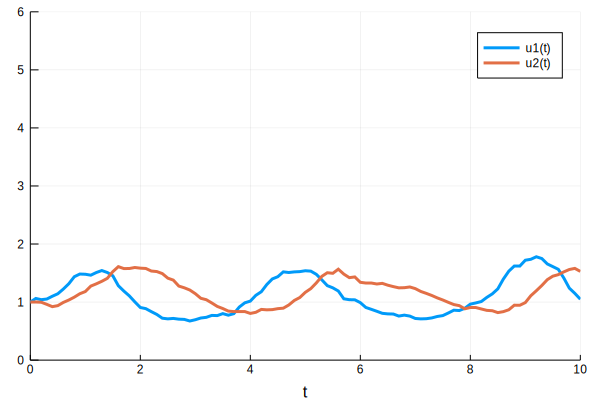

8.439997461806497 (tracked)

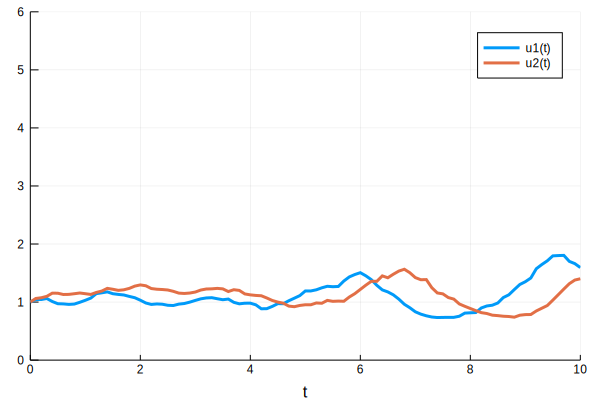

5.865725538267601 (tracked)

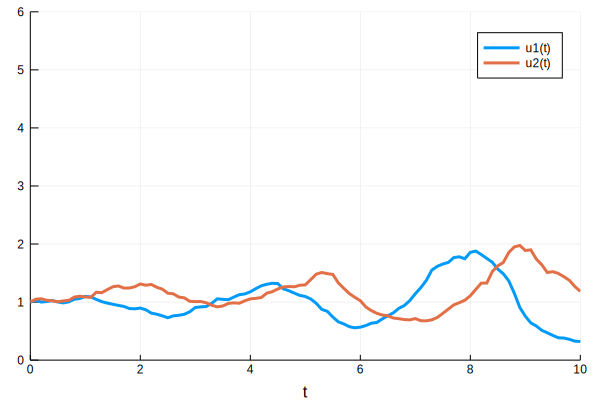

13.62108713434641 (tracked)

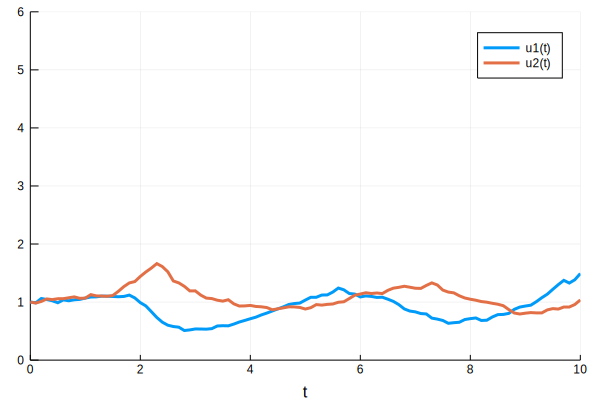

6.732652396773162 (tracked)

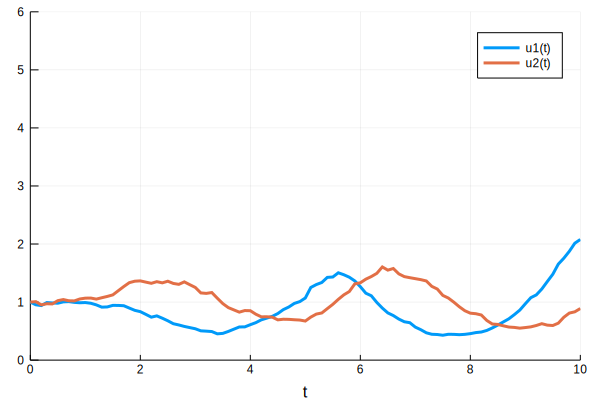

3.146185205532902 (tracked)

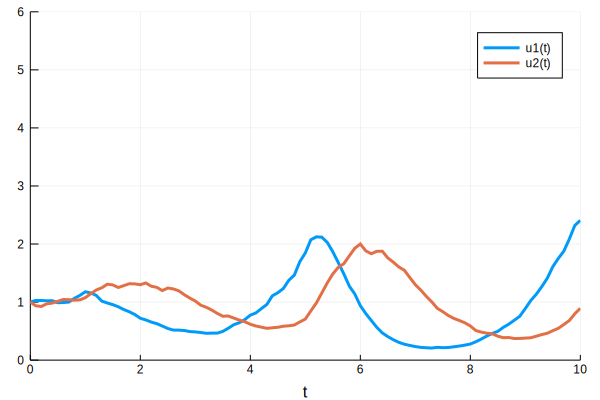

9.386289727412496 (tracked)

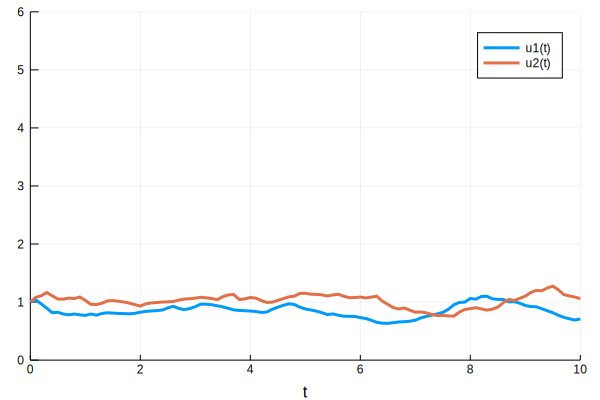

4.41263522503744 (tracked)

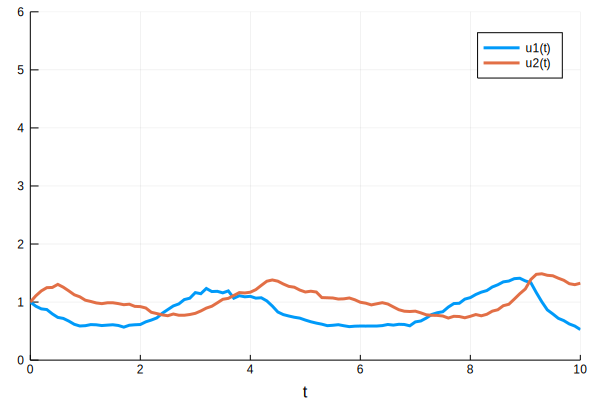

10.990240495157714 (tracked)

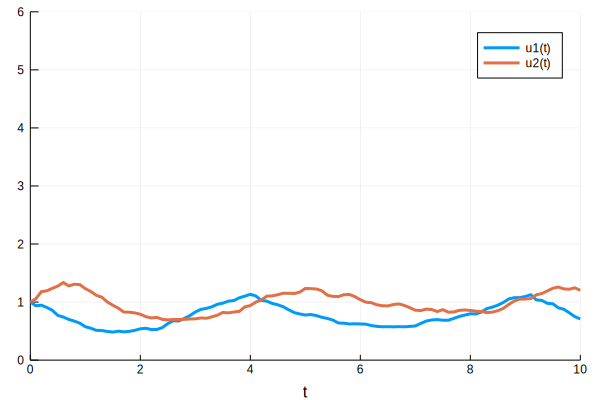

7.9529954861686845 (tracked)

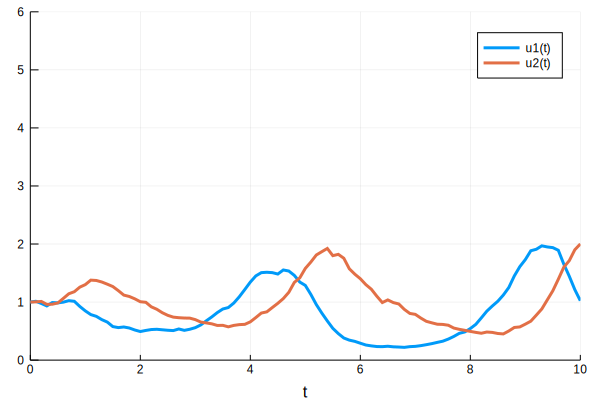

13.309872403549232 (tracked)

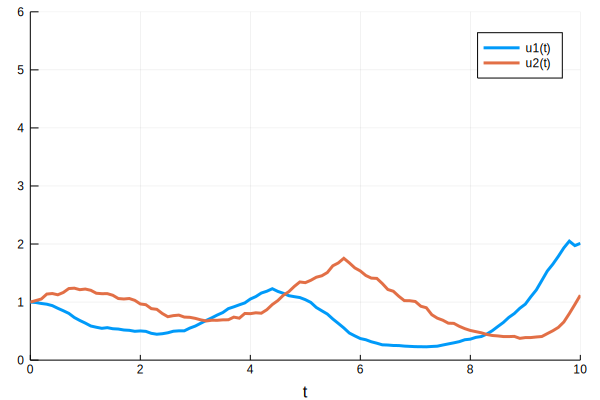

8.850268944673646 (tracked)

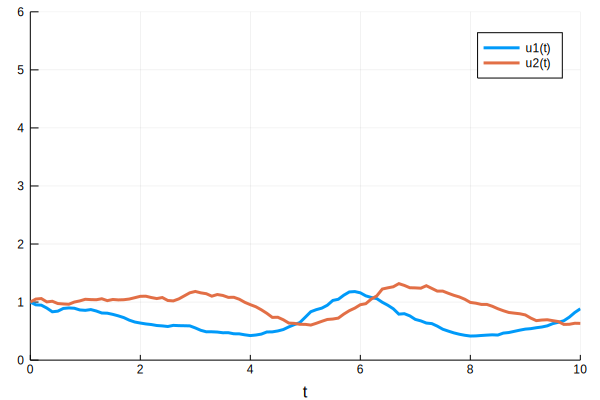

16.14002911955981 (tracked)

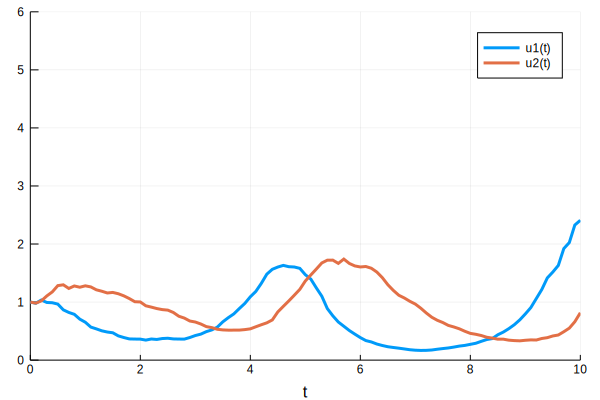

12.629447217884334 (tracked)

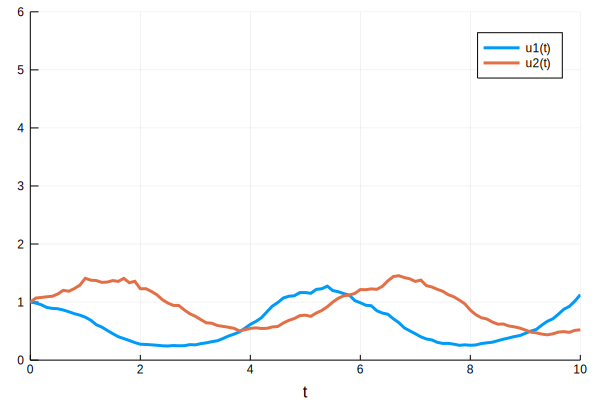

24.959422277991045 (tracked)

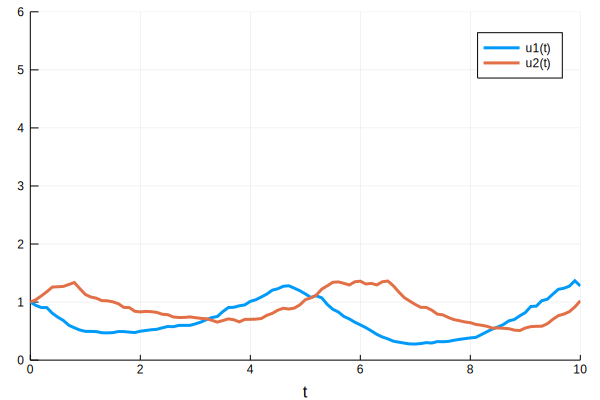

13.872468572266913 (tracked)

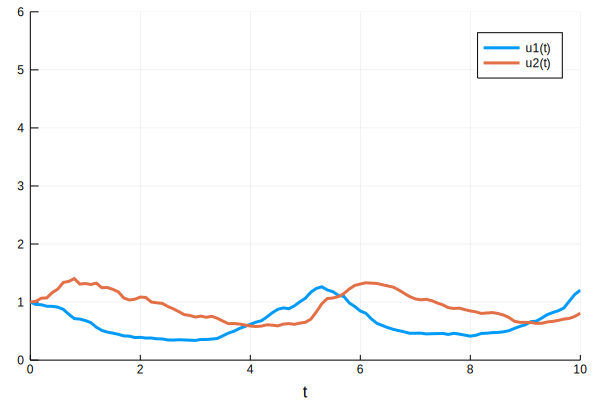

13.777372882027457 (tracked)

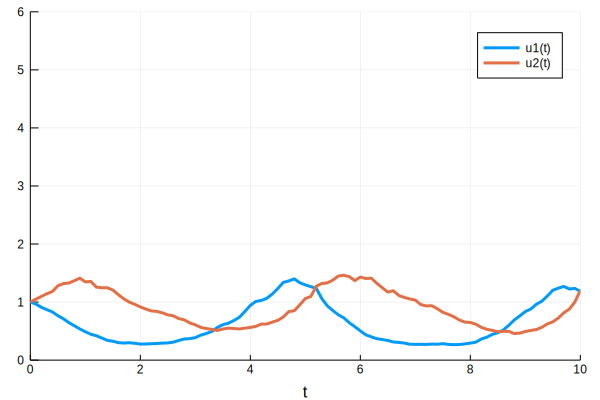

22.402139692890373 (tracked)

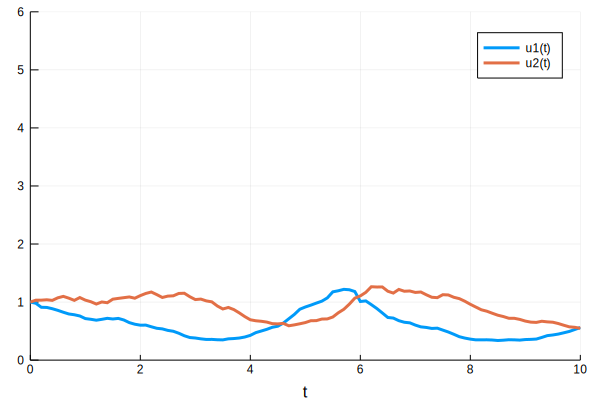

19.869148276688268 (tracked)

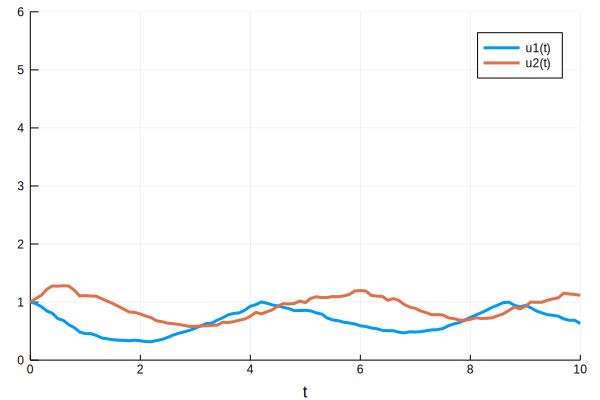

32.21713213892704 (tracked)

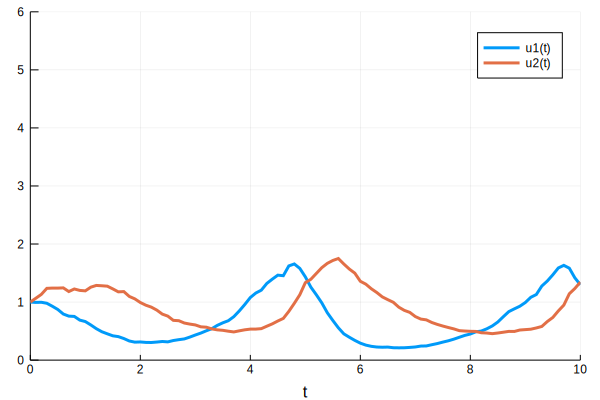

31.983615423629185 (tracked)

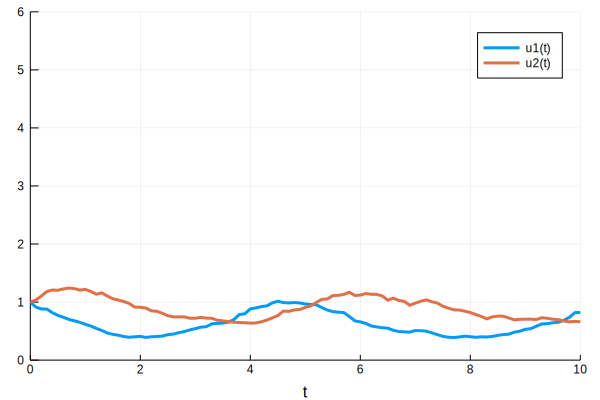

11.961532075809979 (tracked)

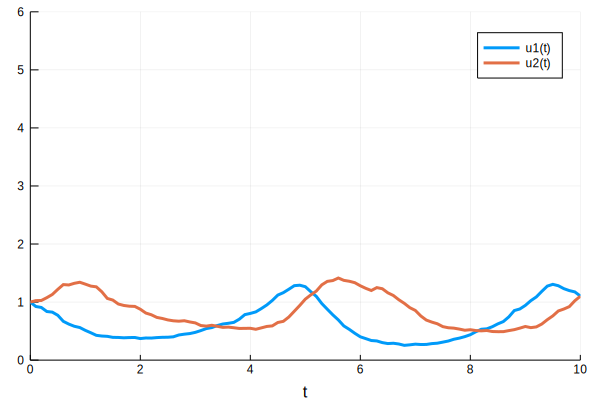

18.83971973596034 (tracked)

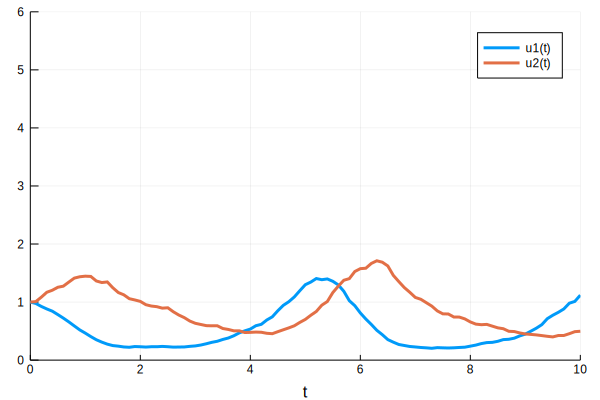

25.209138414883004 (tracked)

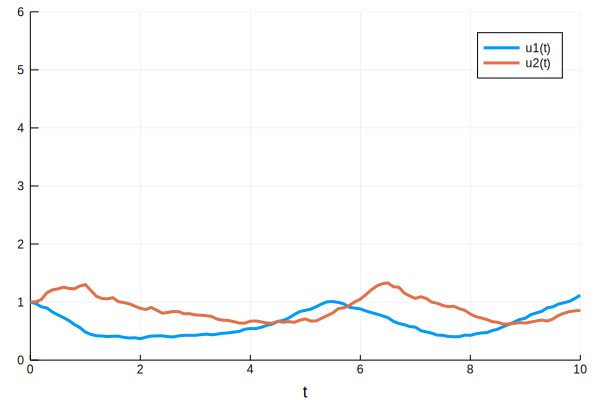

21.72762955386217 (tracked)

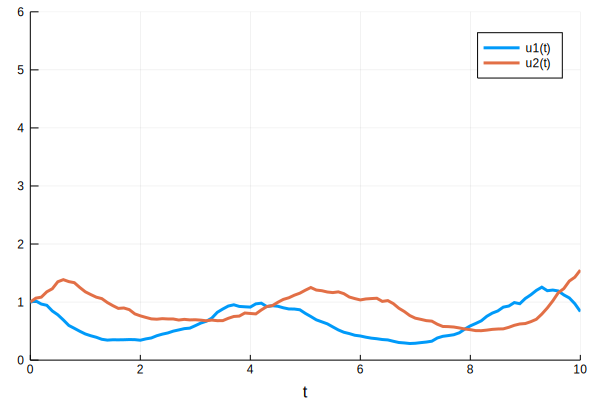

25.291885922293663 (tracked)

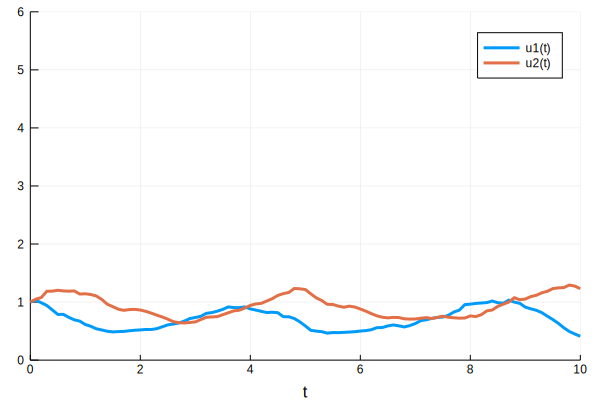

18.14391939066758 (tracked)

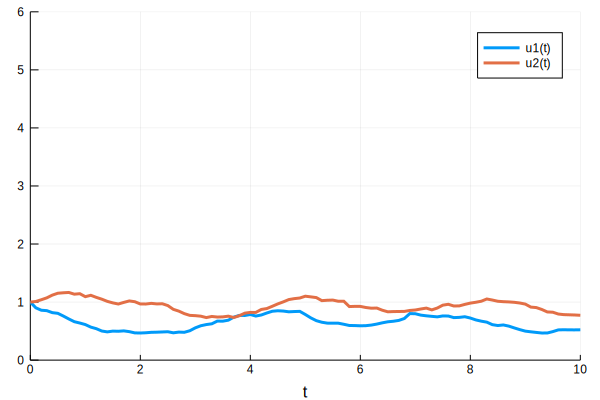

20.548586108192094 (tracked)

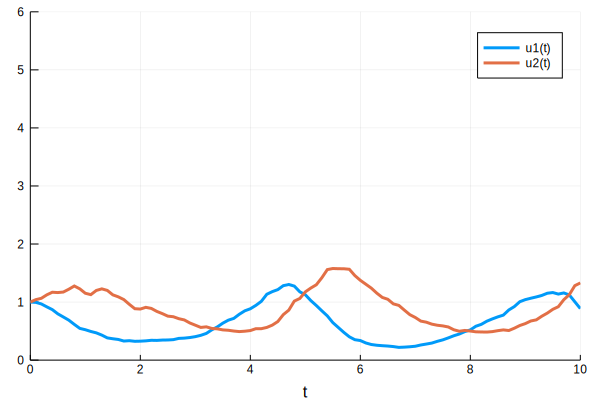

17.782633453513235 (tracked)

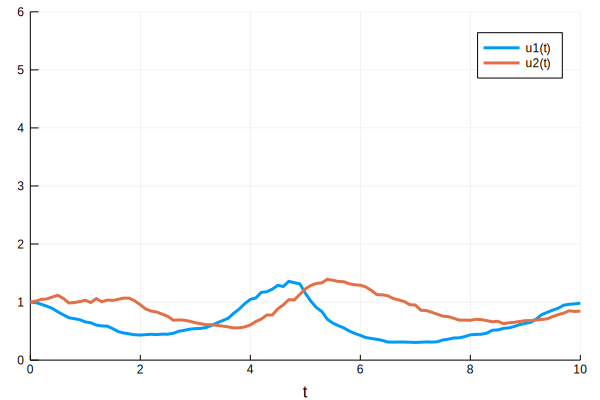

26.234880231469408 (tracked)

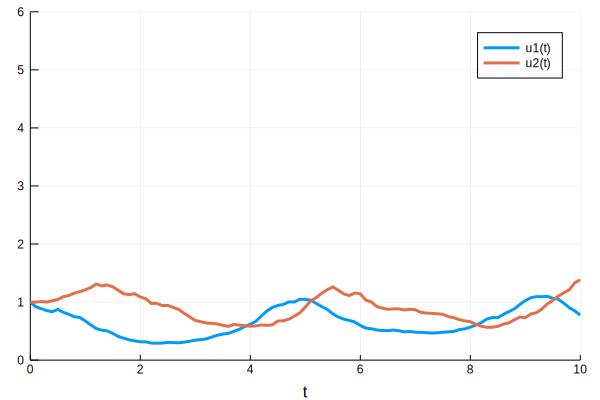

12.192393689711137 (tracked)

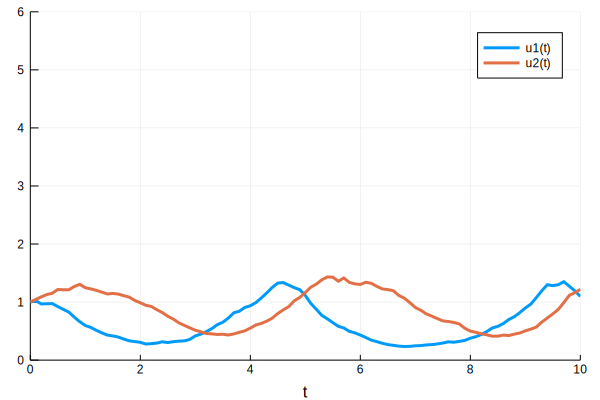

14.578344395658695 (tracked)

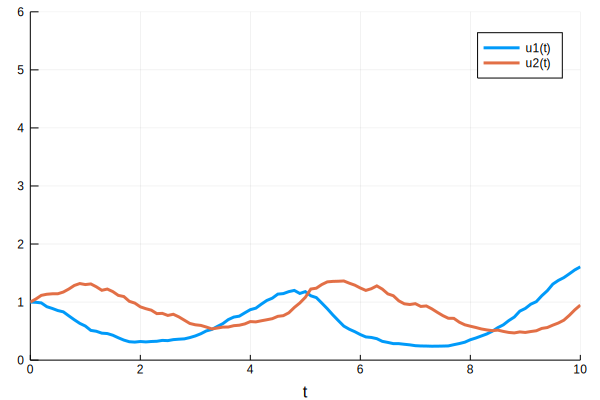

19.936891403078427 (tracked)

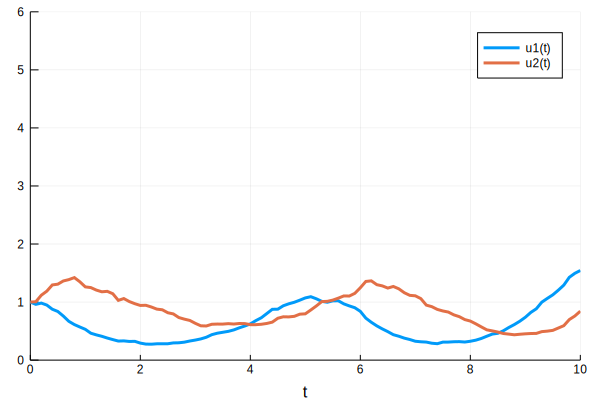

28.41116925860157 (tracked)

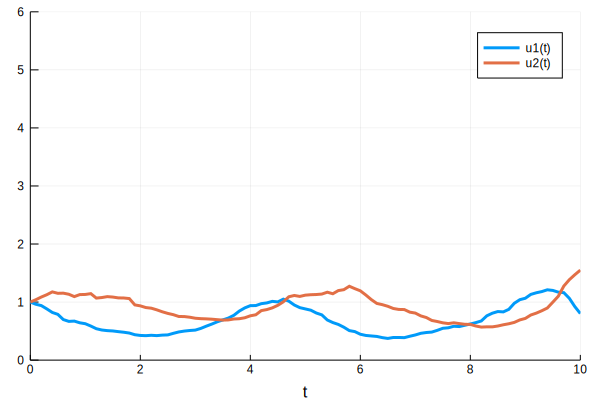

13.77133219963773 (tracked)

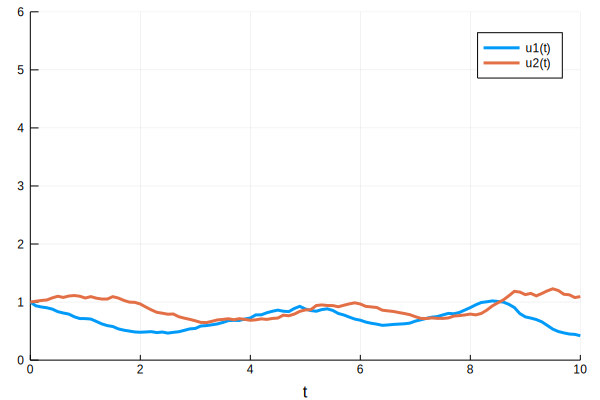

17.865648288780577 (tracked)

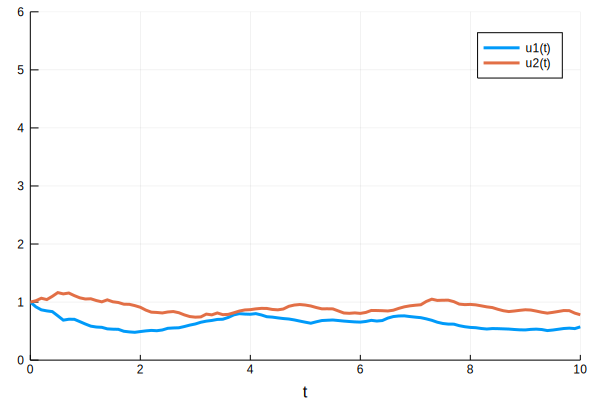

14.990652112069876 (tracked)

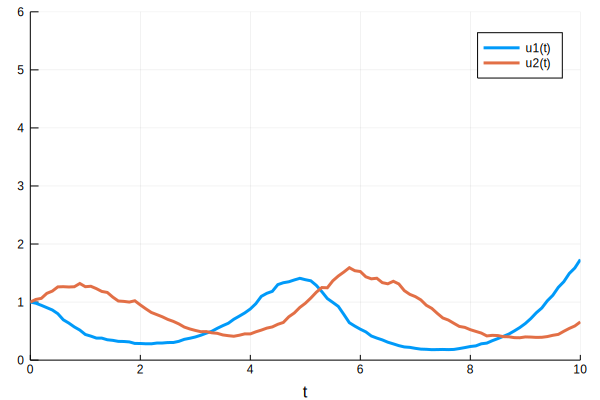

21.913590019729423 (tracked)

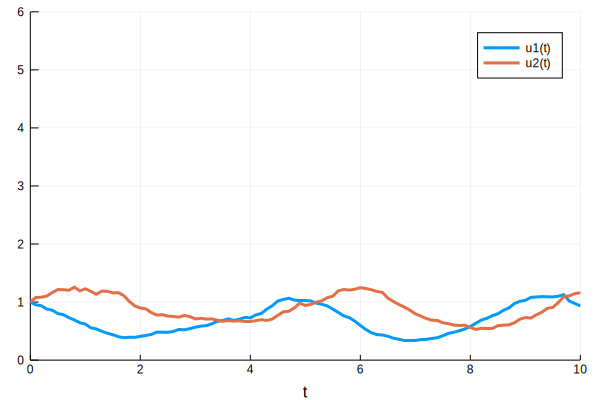

14.511765472202311 (tracked)

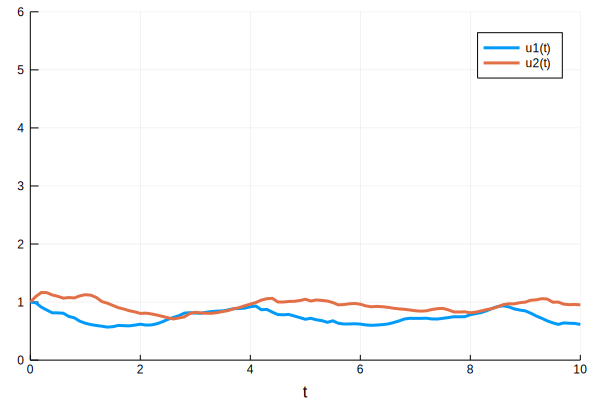

12.506403904545836 (tracked)

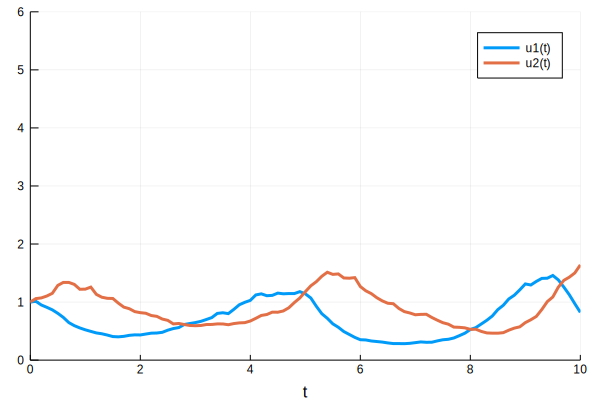

13.738099864124957 (tracked)

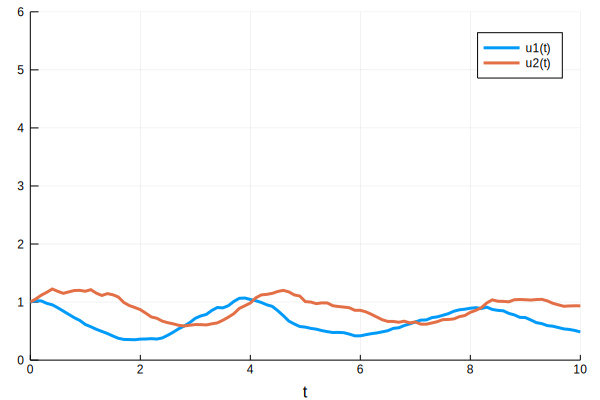

10.35252273433835 (tracked)

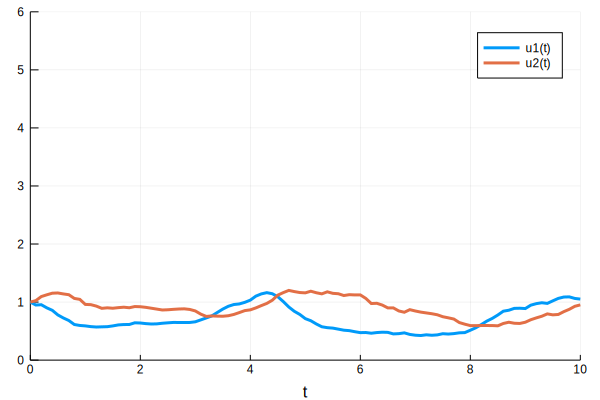

13.348073319229393 (tracked)

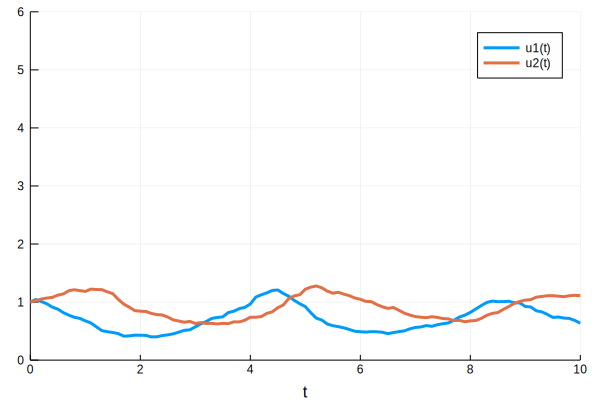

17.575033099469344 (tracked)

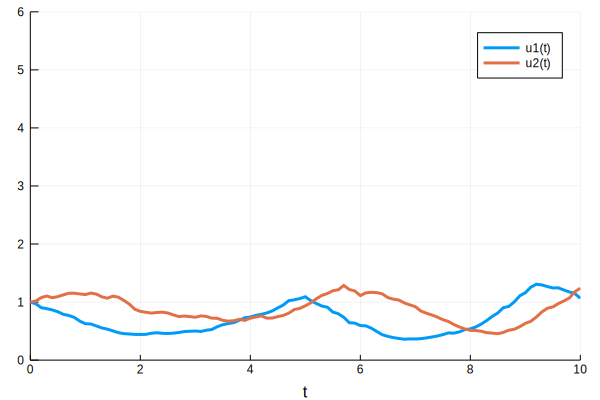

15.821903389911386 (tracked)

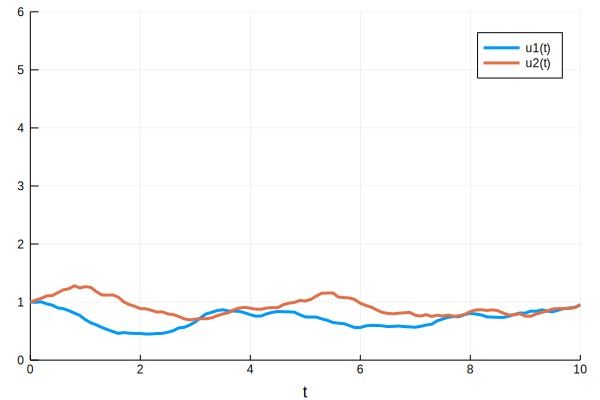

18.158772655779455 (tracked)

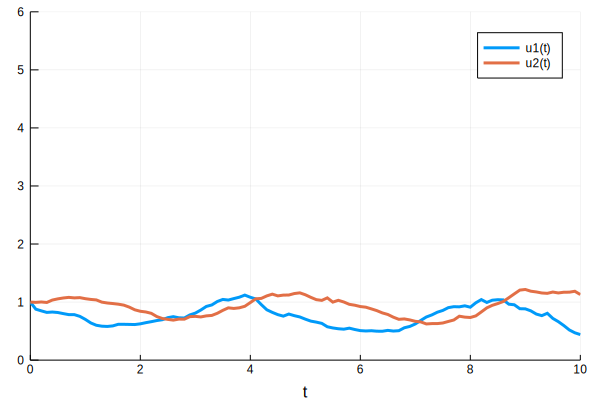

15.093771553104618 (tracked)

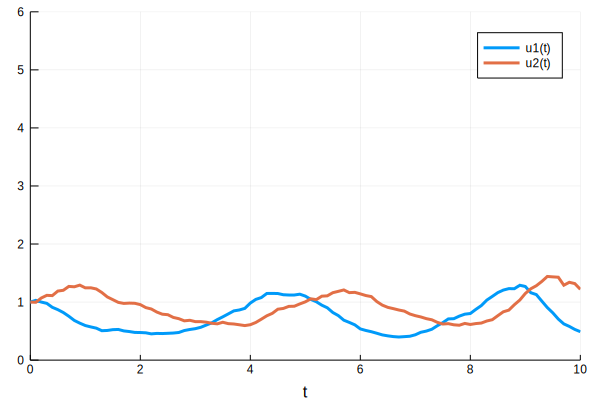

7.099807536267526 (tracked)

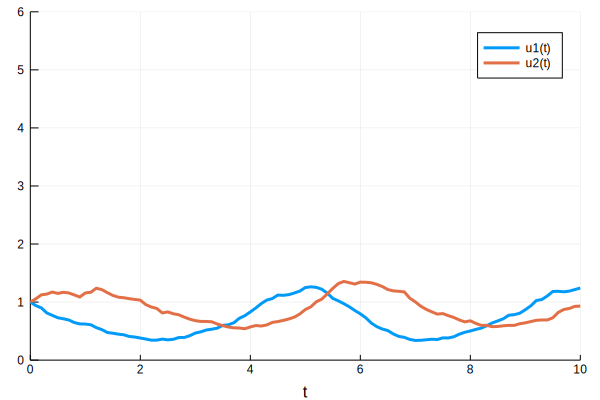

11.61195889602864 (tracked)

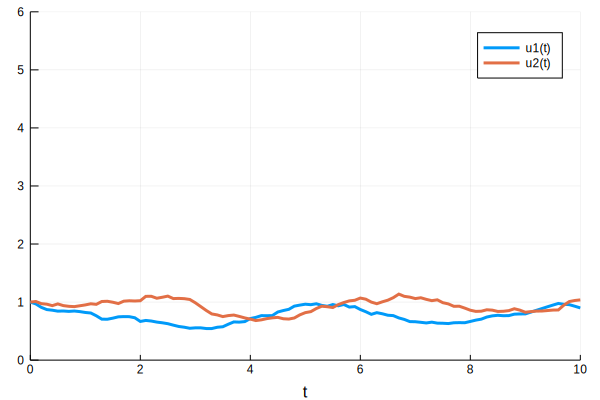

16.266686807722643 (tracked)

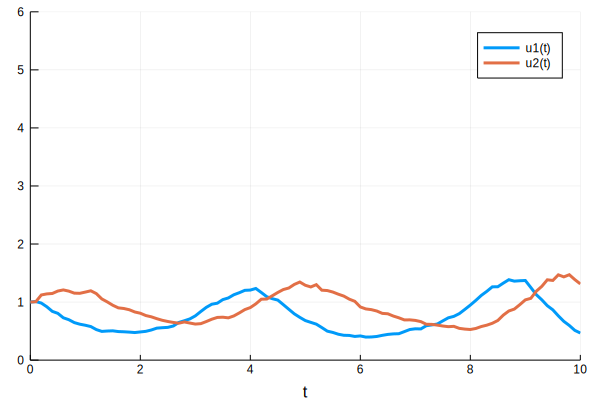

7.764922037278819 (tracked)

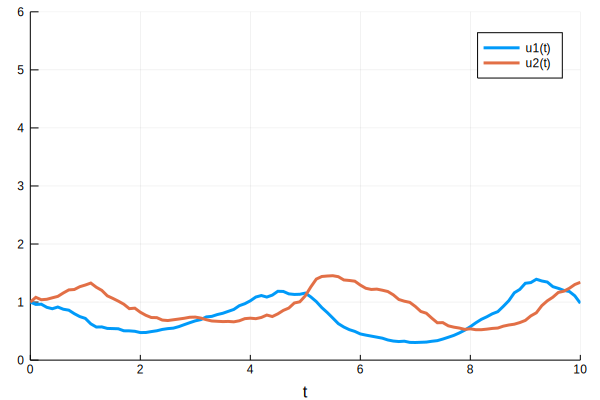

10.277932866708413 (tracked)

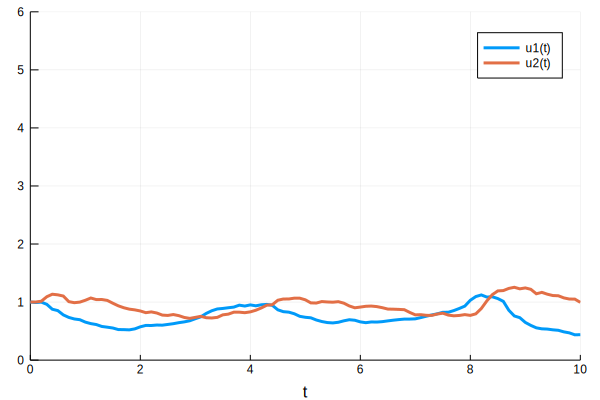

19.575569114646743 (tracked)

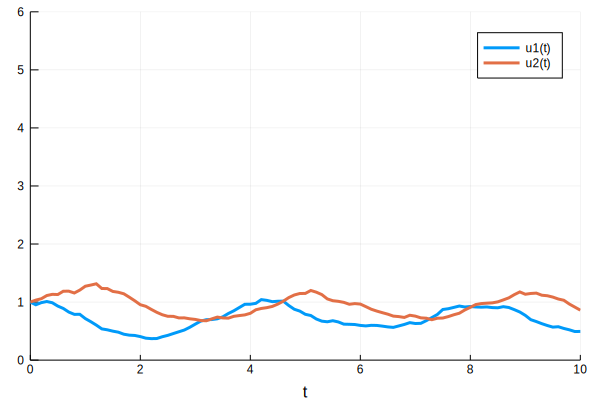

10.256967062982783 (tracked)

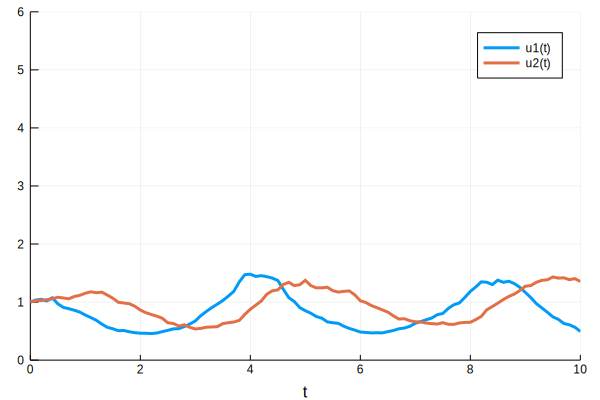

16.216961301993546 (tracked)

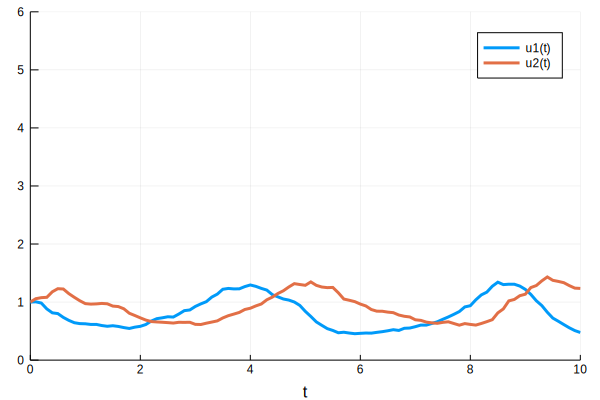

13.903400002965927 (tracked)

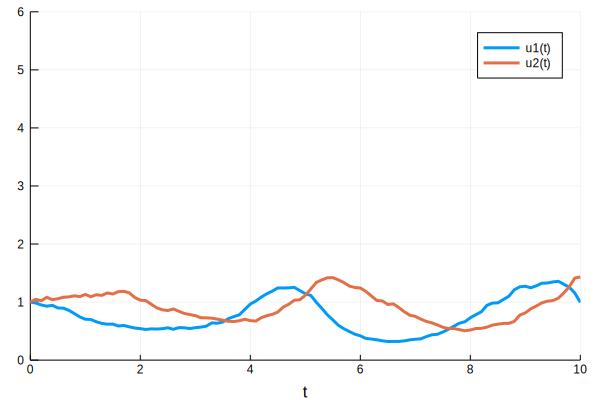

8.252438819156273 (tracked)

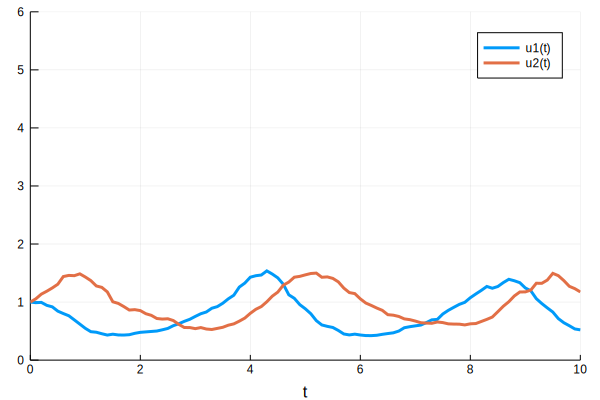

5.458966930405895 (tracked)

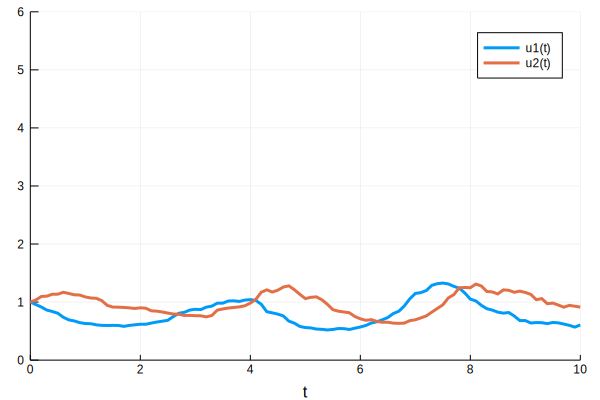

15.380104753610611 (tracked)

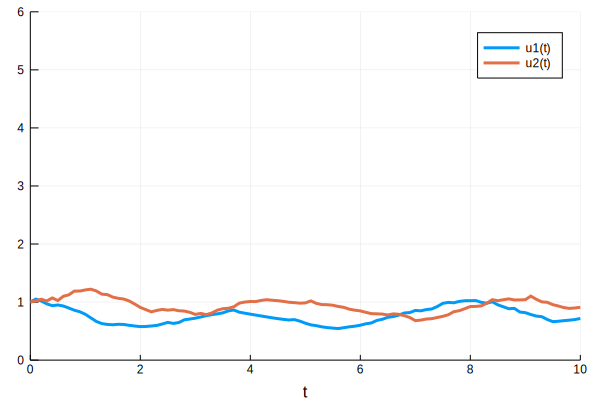

21.132004216771943 (tracked)

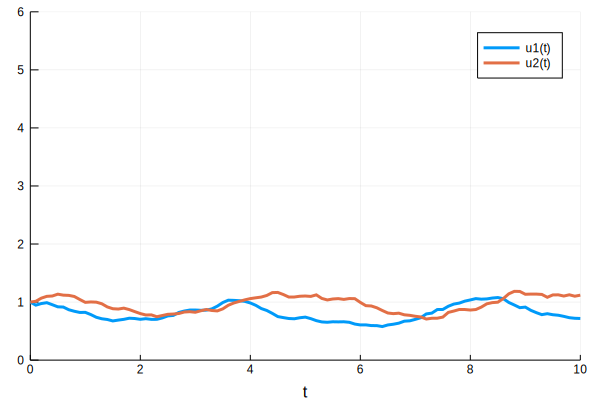

10.33436543810044 (tracked)

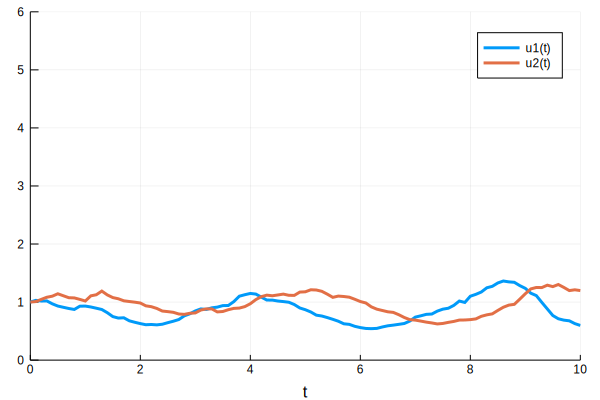

15.116966036237395 (tracked)

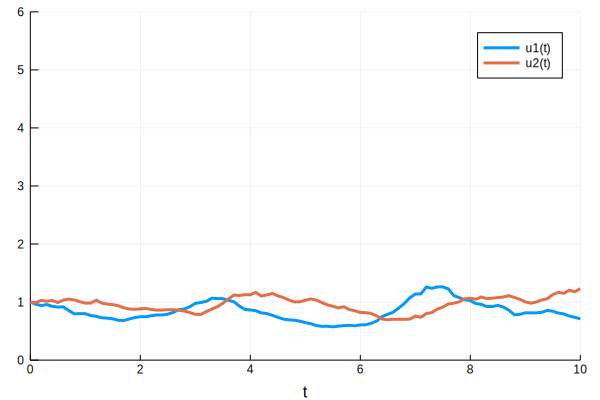

14.260509676750152 (tracked)

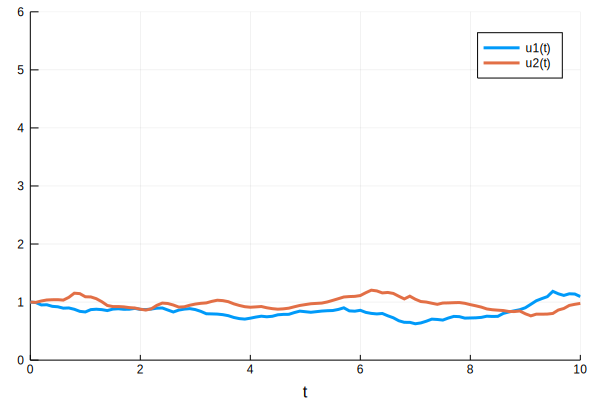

25.8388599762989 (tracked)

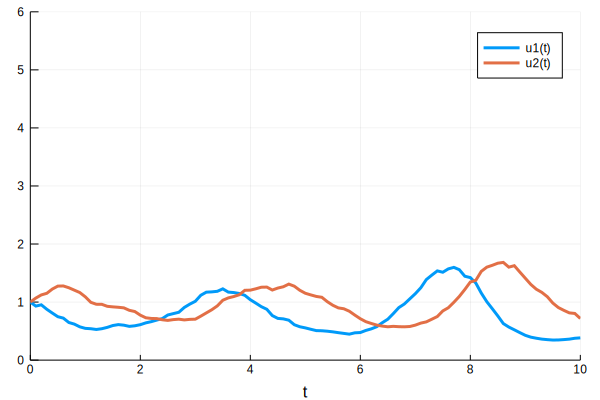

3.967487797246647 (tracked)

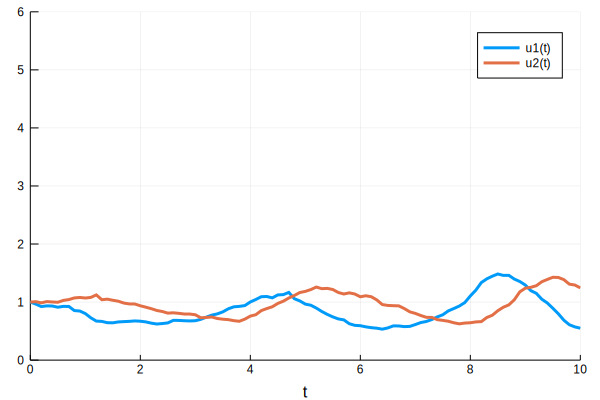

12.10869909723505 (tracked)

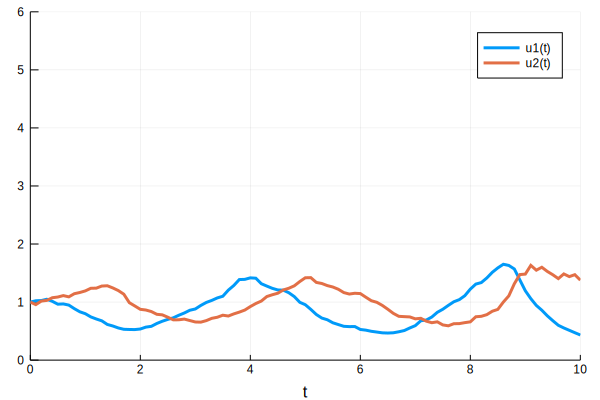

8.476874910670743 (tracked)

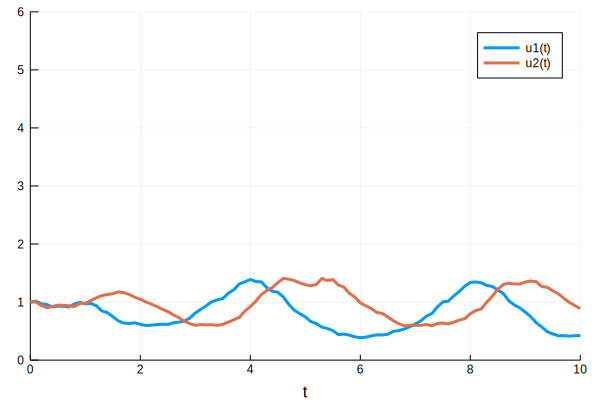

27.33136251079199 (tracked)

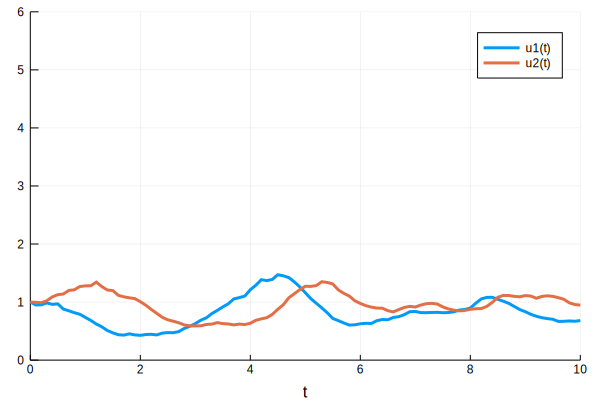

6.743152126528426 (tracked)

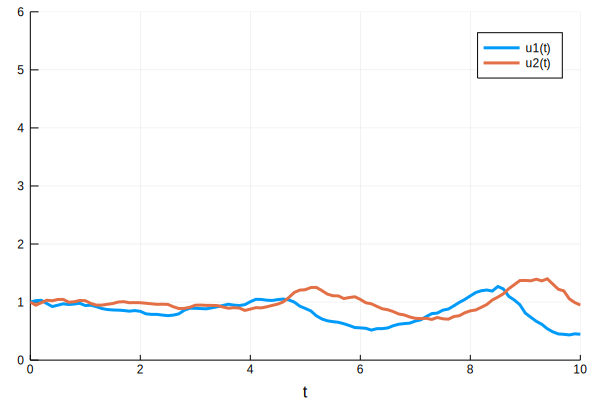

3.7506761943324816 (tracked)

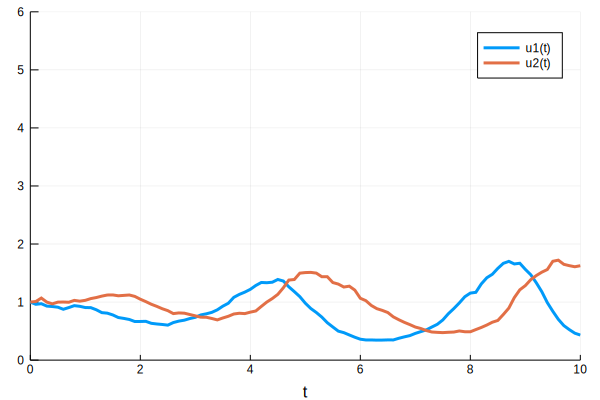

11.634607335870356 (tracked)

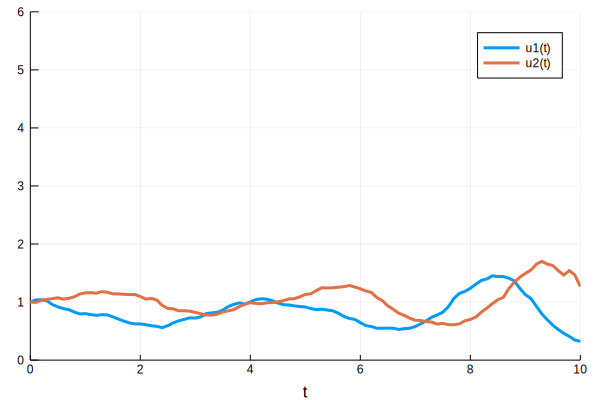

12.130231153720107 (tracked)

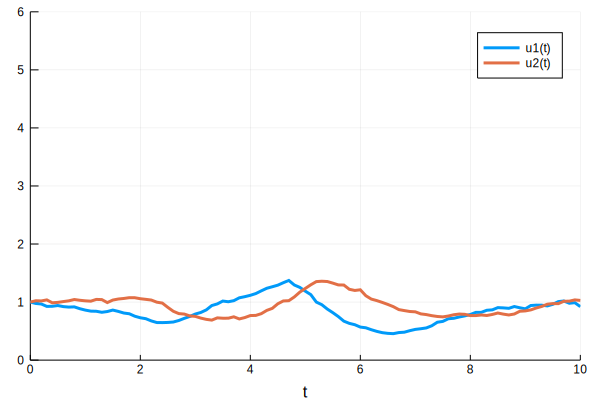

4.786435655606859 (tracked)

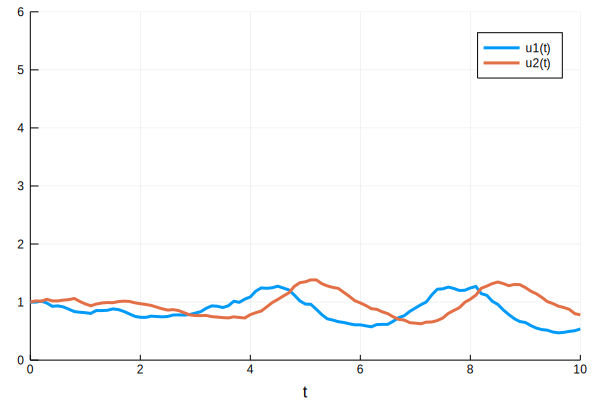

8.04107406924361 (tracked)

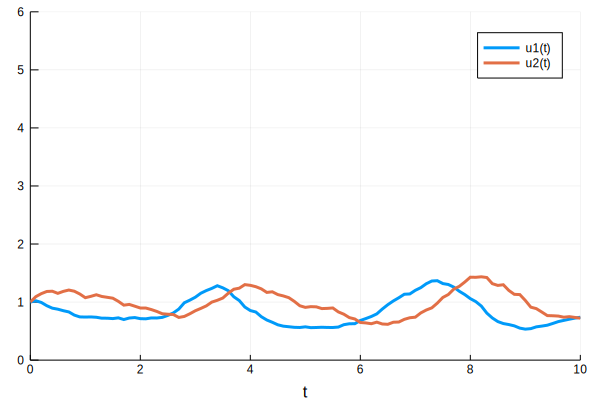

5.891757497704872 (tracked)

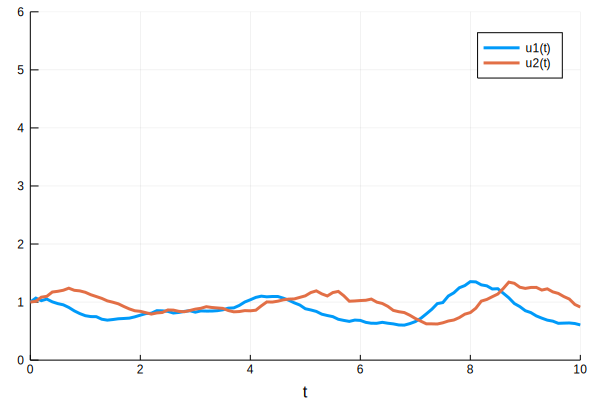

6.887966541434461 (tracked)

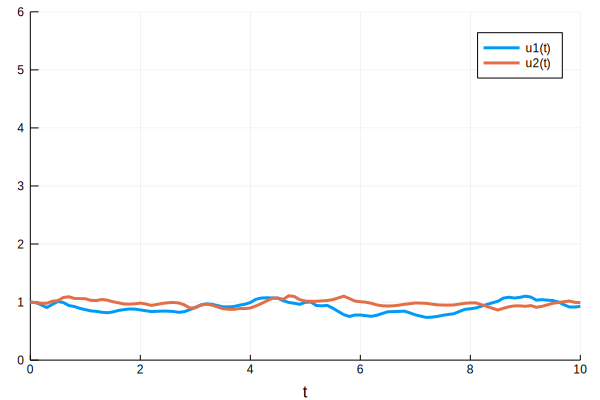

2.989589433358701 (tracked)

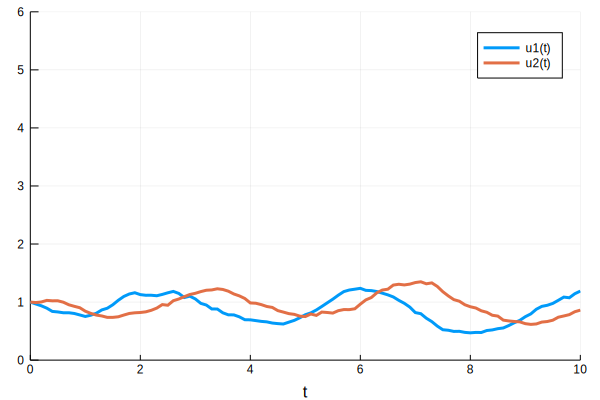

4.7739230021292185 (tracked)

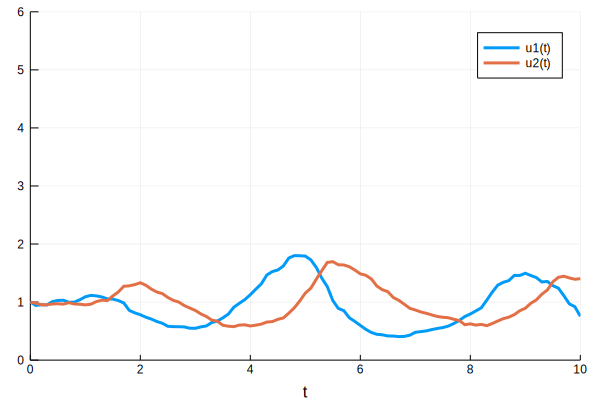

6.7341727540791885 (tracked)

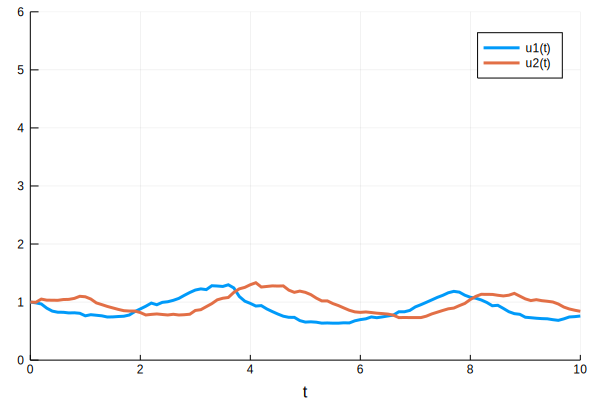

5.326459946584173 (tracked)

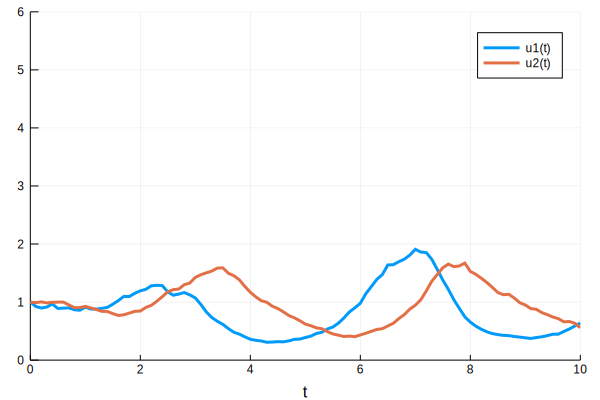

3.3416425585202436 (tracked)

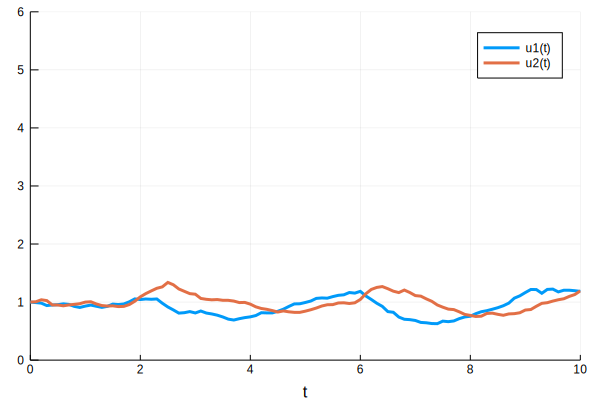

16.874014348407243 (tracked)

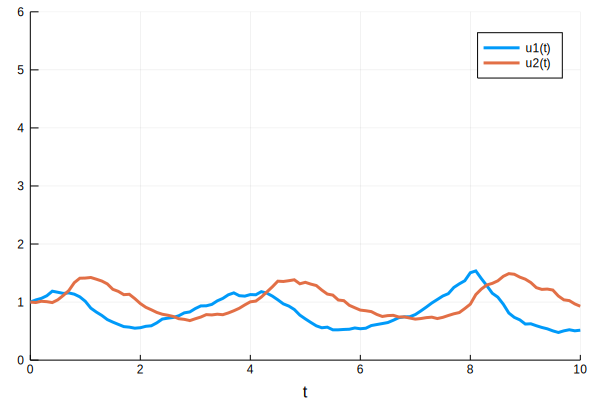

4.434266748099212 (tracked)

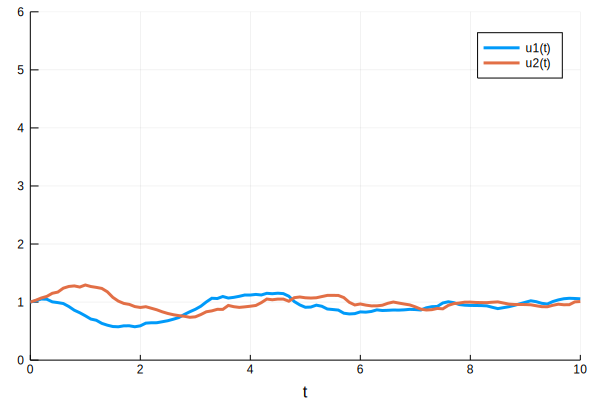

6.595416725860169 (tracked)

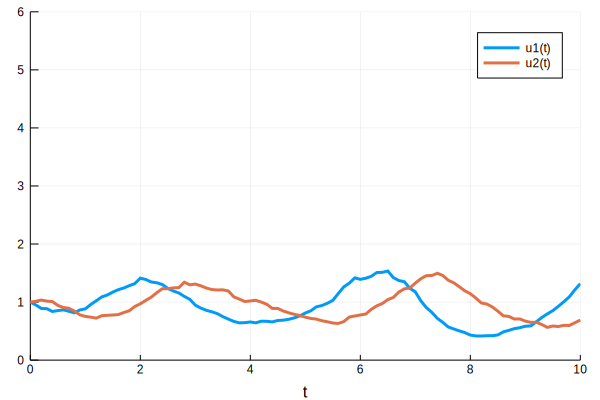

4.4260090787728785 (tracked)

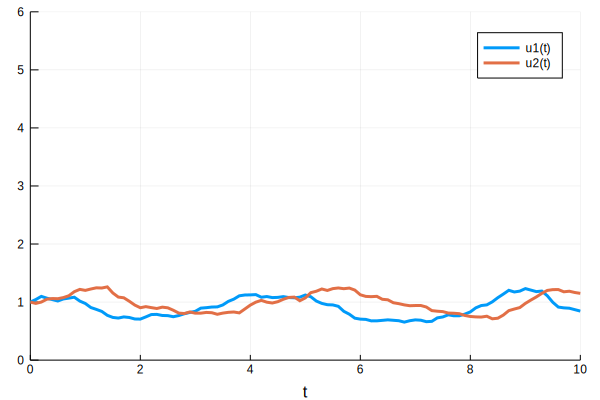

4.199599067702862 (tracked)

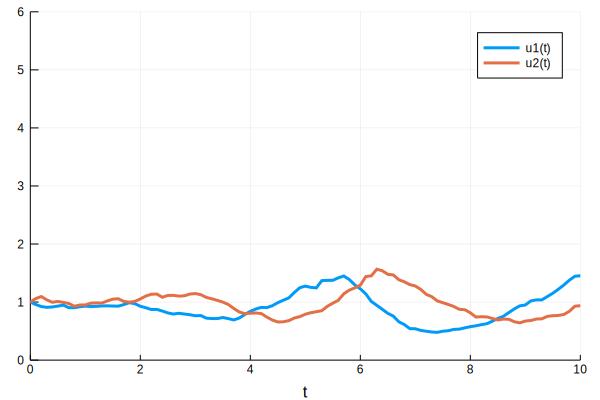

4.235147247222503 (tracked)

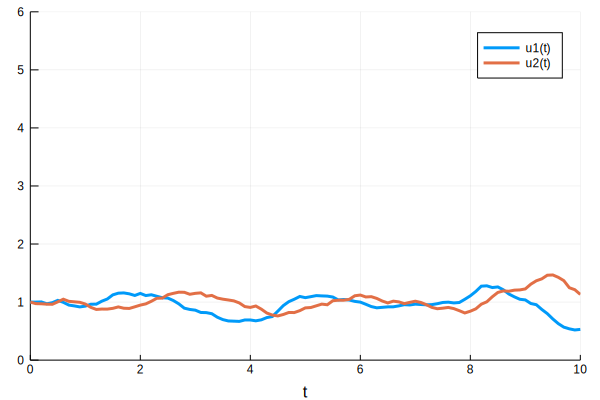

6.399933104853274 (tracked)

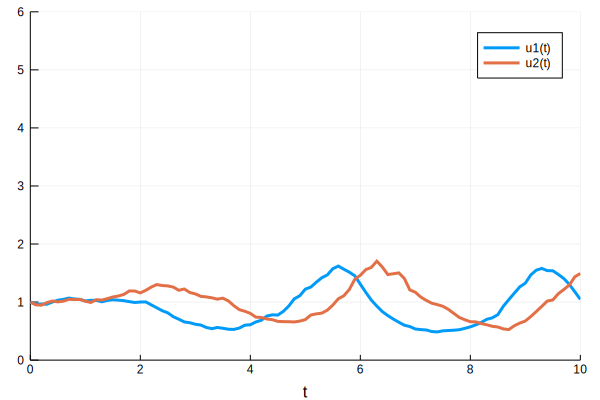

3.7317529514139327 (tracked)

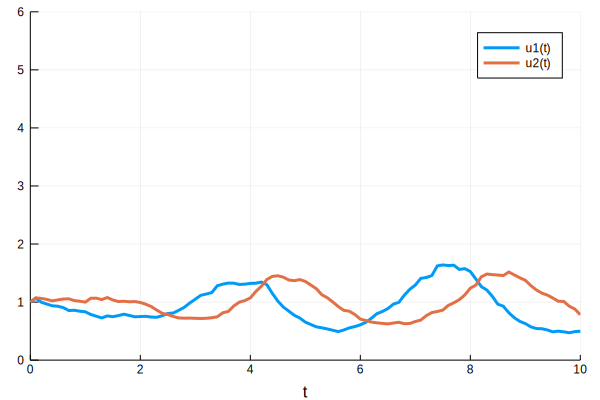

4.254277669932326 (tracked)

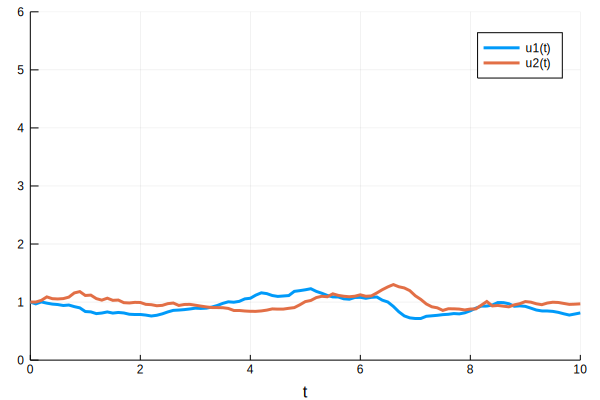

In [12]:
function lotka_volterra_noise(du,u,p,t)
  du[1] = 0.1u[1]
  du[2] = 0.1u[2]
end
prob = SDEProblem(lotka_volterra,lotka_volterra_noise,[1.0,1.0],(0.0,10.0))

p = param([2.2, 1.0, 2.0, 0.4])
params = Flux.Params([p])
function predict_fd_sde()
  diffeq_fd(p,sol->sol[1,:],101,prob,SOSRI(),saveat=0.1)
end
loss_fd_sde() = sum(abs2,x-1 for x in predict_fd_sde())
loss_fd_sde()
data = Iterators.repeated((), 100)
opt = ADAM(0.1)
cb = function ()
  display(loss_fd_sde())
  display(plot(solve(remake(prob,p=Flux.data(p)),SOSRI(),saveat=0.1),ylim=(0,6)))
end

# Display the ODE with the current parameter values.
cb()

Flux.train!(loss_fd_sde, params, data, opt, cb = cb)

If we go back to the beginning we said that we could solve 
the entire neural network as we would a differential equation.

We can define a multilayer perceptron with 1 hidden layer and
a tanh activation function like: 

In [14]:
dudt = Chain(Dense(2,50,tanh), Dense(50,2))
#2-->50-->2

Chain(Dense(2, 50, tanh), Dense(50, 2))

To define a neural ode layer we then just need to give it a timespan and ise the neural_ode function:

In [15]:
tspan = (0.0f0,25.0f0)
x->neural_ode(dudt,x,tspan,Tsit5(),saveat=0.1)

#25 (generic function with 1 method)

Lets use the layer to create an example. First we generate a time series of an ODE at evenly spaced time points.

In [16]:
u0 = Float32[2.; 0.]
datasize = 30
tspan = (0.0f0,1.5f0)

function trueODEfunc(du,u,p,t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end
t = range(tspan[1],tspan[2],length=datasize)
prob = ODEProblem(trueODEfunc,u0,tspan)
ode_data = Array(solve(prob,Tsit5(),saveat=t))

2×30 Array{Float32,2}:
 2.0  1.94651   1.74178  1.23835  0.577128  …  1.40969   1.37179   1.29075 
 0.0  0.798833  1.46473  1.80875  1.86464      0.462541  0.741123  0.984491

We want to pit a neural ODE against this data. So we create the neural ODE.

In [17]:
dudt = Chain(x -> x.^3,
             Dense(2,50,tanh),
             Dense(50,2))
ps = Flux.params(dudt)
n_ode(x) = neural_ode(dudt,x,tspan,Tsit5(),saveat=t,reltol=1e-7,abstol=1e-9)

n_ode (generic function with 1 method)

This has the same timespan and saveat as the solution that 
generated the data. Given an x (and initial value), it will
generate a guess for what it things the time series will be where
the structure is predicted by the internal neural network.

Before training the first variable looks like the following:

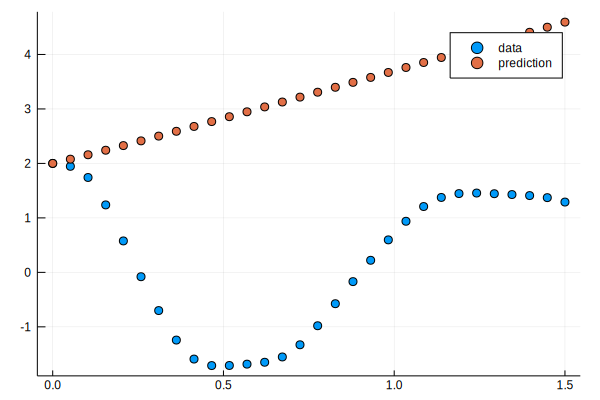

In [18]:
pred = n_ode(u0) # Get the prediction using the correct initial condition
scatter(t,ode_data[1,:],label="data")
scatter!(t,Flux.data(pred[1,:]),label="prediction")

Now we train the neural network

First we create a function that gives a prediction and then define the loss

In [19]:
function predict_n_ode()
  n_ode(u0)
end
loss_n_ode() = sum(abs2,ode_data .- predict_n_ode())

loss_n_ode (generic function with 1 method)

390.15f0 (tracked)

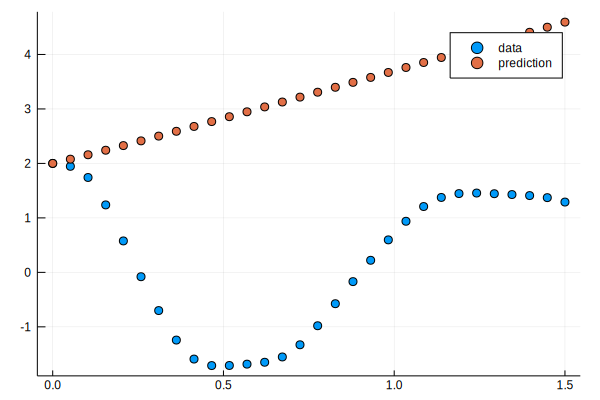

In [ ]:
data = Iterators.repeated((), 1000)
opt = ADAM(0.1)
cb = function () #callback function to observe training
  display(loss_n_ode())
  # plot current prediction against data
  cur_pred = Flux.data(predict_n_ode())
  pl = scatter(t,ode_data[1,:],label="data")
  scatter!(pl,t,cur_pred[1,:],label="prediction")
  display(plot(pl))
end

# Display the ODE with the initial parameter values.
cb()

Flux.train!(loss_n_ode, ps, data, opt, cb = cb)

It learns a compact representatino of how the time series works, and it can easily extrapolate to what would happen with different starting conditions 